In [264]:
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

%matplotlib inline

In [265]:
# Read in average monthly temperature by state data
monthly_temps_path = 'Resources/average_monthly_temperature_by_state_1950-2022.csv'
monthly_temps_df = pd.read_csv(monthly_temps_path,
                               index_col='year')

In [266]:
# The Adidas dataset only has the two years 2020 & 2021, Clean for the relevant years
monthly_temps_df = monthly_temps_df.loc['2020':'2021']

monthly_temps_df = monthly_temps_df.rename_axis('Year')

# Clean columns
monthly_temps_df.drop(['Unnamed: 0', 'monthly_mean_from_1901_to_2000', 'centroid_lon', 'centroid_lat'], axis=1, inplace=True)

monthly_temps_df = monthly_temps_df.rename(
    columns={
        'month': 'Month',
        'state': 'State',
        'average_temp': 'Average Temp'
    }
)

In [267]:
monthly_temps_df.head()

,Month,State,Average Temp
Year,,,
2020,1,Alabama,50.4
2020,1,Arizona,43.0
2020,1,Arkansas,44.8
2020,1,California,44.8
2020,1,Colorado,27.8


In [268]:
# Resetting index to prep 'Year' for datetime type conversion
monthly_temps_df = monthly_temps_df.reset_index()

In [269]:
# Merging Year and Month columns as a datetime dtype
monthly_temps_df['Date'] = pd.to_datetime(monthly_temps_df['Year'].astype(str) + '-' + monthly_temps_df['Month'].astype(str).str.zfill(2))

# Dropping the irrelevent 'Days' as they all show as xx-xx-01
monthly_temps_df['Date'] = monthly_temps_df['Date'].dt.to_period('M')

# Setting index to the new datetime 'Date' column
monthly_temps_df = monthly_temps_df.set_index('Date')

# Dropping the now irrelevant duplicate columns
monthly_temps_df.drop(['Year', 'Month'], axis=1, inplace=True)


In [270]:
# Check the dtype conversion is correct
monthly_temps_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1152 entries, 2020-01 to 2021-12
Freq: M
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         1152 non-null   object 
 1   Average Temp  1152 non-null   float64
dtypes: float64(1), object(1)
memory usage: 27.0+ KB


In [271]:
# Check the formatting is correct
display(monthly_temps_df.head(10))
display(monthly_temps_df.tail(10))

,State,Average Temp
Date,,
2020-01,Alabama,50.4
2020-01,Arizona,43.0
2020-01,Arkansas,44.8
2020-01,California,44.8
2020-01,Colorado,27.8
2020-01,Connecticut,32.4
2020-01,Delaware,40.1
2020-01,Florida,62.8
2020-01,Georgia,51.8


,State,Average Temp
Date,,
2021-12,South Dakota,31.4
2021-12,Tennessee,48.0
2021-12,Texas,58.2
2021-12,Utah,36.8
2021-12,Vermont,31.2
2021-12,Virginia,45.2
2021-12,Washington,34.7
2021-12,West Virginia,41.8
2021-12,Wisconsin,29.3


In [272]:
# Groupby State, Year, and Month to sort
monthly_temps_by_state = monthly_temps_df.groupby(['State', monthly_temps_df.index.year, monthly_temps_df.index.month])['Average Temp'].sum()

display(monthly_temps_by_state.head(10))
display(monthly_temps_by_state.tail(10))

State    Date  Date
Alabama  2020  1       50.4
               2       50.2
               3       57.2
               4       62.8
               5       65.4
               6       72.9
               7       78.9
               8       80.6
               9       77.2
               10      70.6
Name: Average Temp, dtype: float64

State    Date  Date
Wyoming  2021  3       24.8
               4       35.0
               5       43.4
               6       56.8
               7       67.4
               8       67.1
               9       61.1
               10      51.0
               11      40.2
               12      31.3
Name: Average Temp, dtype: float64

In [273]:
# Rename the Indexes
monthly_temps_by_state.index.names = ['State', 'Year', 'Month']

monthly_temps_by_state.head()

State    Year  Month
Alabama  2020  1        50.4
               2        50.2
               3        57.2
               4        62.8
               5        65.4
Name: Average Temp, dtype: float64

In [274]:
# Save Cleaned temperature data csv
#monthly_temps_by_state.to_csv('Resources/avg_temps_cleaned.csv')


In [275]:
# Read in the Adidas xlsx
adidas_path = 'Resources/Round 4 Year_Adidas_Sales_Data_Monthly_Category_Summary.csv'
adidas_df = pd.read_csv(adidas_path,
                          index_col='Invoice Date',
                          parse_dates=True,
                          date_format='dateutil')


In [276]:
# See what we're dealing with
adidas_df.head()

,Year,Month_Number,Month_Name,Region,State,City,Category,Subcategory,Product,Price per Unit,Units Sold,Total Sales,Profit per Unit,Operating Margin,Total Operating Profit,Year-Month
Invoice Date,,,,,,,,,,,,,,,,
2020-01-01,2020,1,Jan,Northeast,New York,New York,Street Footwear,Men's,Men's Street Footwear,50.0,1200,60000,25.00,0.50,30000.0,2020-01
2020-01-02,2020,1,Jan,Northeast,New York,New York,Athletic Footwear,Men's,Men's Athletic Footwear,50.0,1000,50000,15.00,0.30,15000.0,2020-01
2020-01-03,2020,1,Jan,Northeast,New York,New York,Street Footwear,Women's,Women's Street Footwear,40.0,1000,40000,14.00,0.35,14000.0,2020-01
2020-01-04,2020,1,Jan,Northeast,New York,New York,Athletic Footwear,Women's,Women's Athletic Footwear,45.0,850,38250,15.75,0.35,13387.5,2020-01
2020-01-05,2020,1,Jan,Northeast,New York,New York,Apparel,Men's,Men's Apparel,60.0,900,54000,18.00,0.30,16200.0,2020-01


In [277]:
monthly_temps_by_state.head()

State    Year  Month
Alabama  2020  1        50.4
               2        50.2
               3        57.2
               4        62.8
               5        65.4
Name: Average Temp, dtype: float64

In [278]:
adidas_df.columns

Index(['Year', 'Month_Number', 'Month_Name', 'Region', 'State', 'City',
       'Category', 'Subcategory', 'Product', 'Price per Unit', 'Units Sold',
       'Total Sales', 'Profit per Unit', 'Operating Margin',
       'Total Operating Profit', 'Year-Month'],
      dtype='object')

In [279]:
# Clean for relevent data to include Region, State, Product, Price per Unit, Units Sold, and Total Sales

adidas_df.drop(['Month_Name', 'City', 'Product', 'Price per Unit', 'Profit per Unit', 'Operating Margin', 'Total Operating Profit', 'Year-Month'], axis=1, inplace=True)
adidas_df = adidas_df.rename(
    columns={
        'Month_Number': 'Month',
        'Category': 'Product',
        'Subcategory': 'Gender'
    }
)

# Drop NaNs
adidas_df.dropna(inplace=True)

adidas_df.head()

,Year,Month,Region,State,Product,Gender,Units Sold,Total Sales
Invoice Date,,,,,,,,
2020-01-01,2020,1,Northeast,New York,Street Footwear,Men's,1200,60000
2020-01-02,2020,1,Northeast,New York,Athletic Footwear,Men's,1000,50000
2020-01-03,2020,1,Northeast,New York,Street Footwear,Women's,1000,40000
2020-01-04,2020,1,Northeast,New York,Athletic Footwear,Women's,850,38250
2020-01-05,2020,1,Northeast,New York,Apparel,Men's,900,54000


In [280]:
#groupby relevent data to get sum of units sold and total sales
adidas_df = adidas_df.reset_index()

adidas_df.drop(['Invoice Date'],axis=1, inplace=True)

adidas_df = adidas_df.groupby(['State', 'Year', 'Region', 'Month', 'Gender', 'Product'])[['Units Sold', 'Total Sales']].sum()
adidas_df = pd.DataFrame(adidas_df)
display(adidas_df.head())
display(adidas_df.tail())

Units Sold  Total Sales
State   Year Region Month Gender  Product                                   
Alabama 2021 South  8     Men's   Apparel                  2430        91281
                                  Athletic Footwear        4146       111112
                                  Street Footwear          5334       129994
                          Women's Apparel                  4189       137378
                                  Athletic Footwear        2561        75010

Units Sold  Total Sales
State   Year Region Month Gender  Product                                   
Wyoming 2021 West   12    Men's   Athletic Footwear         768        34392
                                  Street Footwear          1024        55648
                          Women's Apparel                   774        45744
                                  Athletic Footwear         635        28440
                                  Street Footwear           715        32010

In [281]:
# checking dtypes
adidas_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3030 entries, ('Alabama', 2021, 'South', 8, "Men's", 'Apparel') to ('Wyoming', 2021, 'West', 12, "Women's", 'Street Footwear')
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Units Sold   3030 non-null   int64
 1   Total Sales  3030 non-null   int64
dtypes: int64(2)
memory usage: 66.0+ KB


In [282]:
#save cleaned df for concatenation with temps df
#adidas_df.to_csv('Resources/aggregated_adidas_data.csv')

In [283]:
#read in cleaned and concatenated data
adidas_concat_path = 'Resources/Concatenated Adidas Sales Data With Temperature.csv'

adidas_concat = pd.read_csv(adidas_concat_path)

adidas_concat.head()

,State,Year,Month,Region,Gender,Product,Units Sold,Total Sales,Average Temp
0,Alabama,2021,8,South,Men's,Apparel,2430,91281,79.7
1,Alabama,2021,8,South,Men's,Athletic Footwear,4146,111112,79.7
2,Alabama,2021,8,South,Men's,Street Footwear,5334,129994,79.7
3,Alabama,2021,8,South,Women's,Apparel,4189,137378,79.7
4,Alabama,2021,8,South,Women's,Athletic Footwear,2561,75010,79.7


In [284]:
#slice to filter for Athletic Footwear sales and temp
adidas_athletic_footwear = adidas_concat[adidas_concat['Product'].str.contains('Athletic')]
display(adidas_athletic_footwear.head())
display(adidas_athletic_footwear.tail())
adidas_athletic_footwear['Product'].unique()

,State,Year,Month,Region,Gender,Product,Units Sold,Total Sales,Average Temp
1,Alabama,2021,8,South,Men's,Athletic Footwear,4146,111112,79.7
4,Alabama,2021,8,South,Women's,Athletic Footwear,2561,75010,79.7
7,Alabama,2021,9,South,Men's,Athletic Footwear,5431,247776,76.9
10,Alabama,2021,9,South,Women's,Athletic Footwear,3682,161302,76.9
13,Alabama,2021,10,South,Men's,Athletic Footwear,2655,103471,70.6


,State,Year,Month,Region,Gender,Product,Units Sold,Total Sales,Average Temp
3016,Wyoming,2021,10,West,Women's,Athletic Footwear,594,26254,51.0
3019,Wyoming,2021,11,West,Men's,Athletic Footwear,742,32889,40.2
3022,Wyoming,2021,11,West,Women's,Athletic Footwear,635,28170,40.2
3025,Wyoming,2021,12,West,Men's,Athletic Footwear,768,34392,31.3
3028,Wyoming,2021,12,West,Women's,Athletic Footwear,635,28440,31.3


array(['Athletic Footwear'], dtype=object)

In [285]:
#groupby visualization for testing
adidas_athletic_footwear = adidas_athletic_footwear.groupby(['State', 'Region', 'Year', 'Month', 'Gender', 'Product', 'Average Temp'])[['Units Sold', 'Total Sales']].sum()
adidas_athletic_footwear = pd.DataFrame(adidas_athletic_footwear)
display(adidas_athletic_footwear.head(10))
display(adidas_athletic_footwear.tail(10))

Units Sold  \
State   Region Year Month Gender  Product           Average Temp               
Alabama South  2021 8     Men's   Athletic Footwear 79.7                4146   
                          Women's Athletic Footwear 79.7                2561   
                    9     Men's   Athletic Footwear 76.9                5431   
                          Women's Athletic Footwear 76.9                3682   
                    10    Men's   Athletic Footwear 70.6                2655   
                          Women's Athletic Footwear 70.6                1760   
Arizona West   2021 1     Men's   Athletic Footwear 42.3                 760   
                          Women's Athletic Footwear 42.3                 511   
                    2     Men's   Athletic Footwear 44.6                 667   
                          Women's Athletic Footwear 44.6                 356   

                                                                  Total Sales  
State   Region Year Month Gender  Product           Average Temp               
Alabama South  2021 8     Men's   Athletic Footwear 79.7               111112  
                          Women's Athletic Footwear 79.7                75010  
                    9     Men's   Athletic Footwear 76.9               247776  
                          Women's Athletic Footwear 76.9               161302  
                    10    Men's   Athletic Footwear 70.6               103471  
                          Women's Athletic Footwear 70.6                90871  
Arizona West   2021 1     Men's   Athletic Footwear 42.3                31581  
                          Women's Athletic Footwear 42.3                21310  
                    2     Men's   Athletic Footwear 44.6                28685  
                          Women's Athletic Footwear 44.6                13162

Units Sold  \
State   Region Year Month Gender  Product           Average Temp               
Wyoming West   2021 8     Men's   Athletic Footwear 67.1                 788   
                          Women's Athletic Footwear 67.1                 672   
                    9     Men's   Athletic Footwear 61.1                 750   
                          Women's Athletic Footwear 61.1                 635   
                    10    Men's   Athletic Footwear 51.0                 774   
                          Women's Athletic Footwear 51.0                 594   
                    11    Men's   Athletic Footwear 40.2                 742   
                          Women's Athletic Footwear 40.2                 635   
                    12    Men's   Athletic Footwear 31.3                 768   
                          Women's Athletic Footwear 31.3                 635   

                                                                  Total Sales  
State   Region Year Month Gender  Product           Average Temp               
Wyoming West   2021 8     Men's   Athletic Footwear 67.1                35134  
                          Women's Athletic Footwear 67.1                26586  
                    9     Men's   Athletic Footwear 61.1                33600  
                          Women's Athletic Footwear 61.1                25130  
                    10    Men's   Athletic Footwear 51.0                34656  
                          Women's Athletic Footwear 51.0                26254  
                    11    Men's   Athletic Footwear 40.2                32889  
                          Women's Athletic Footwear 40.2                28170  
                    12    Men's   Athletic Footwear 31.3                34392  
                          Women's Athletic Footwear 31.3                28440

In [286]:
#set index to State, Region, Year, Month
adidas_athletic_footwear = adidas_athletic_footwear.reset_index()

adidas_athletic_footwear = adidas_athletic_footwear.set_index(['State', 'Region', 'Year', 'Month'])

adidas_athletic_footwear.head()

Gender            Product  Average Temp  \
State   Region Year Month                                             
Alabama South  2021 8        Men's  Athletic Footwear          79.7   
                    8      Women's  Athletic Footwear          79.7   
                    9        Men's  Athletic Footwear          76.9   
                    9      Women's  Athletic Footwear          76.9   
                    10       Men's  Athletic Footwear          70.6   

                           Units Sold  Total Sales  
State   Region Year Month                           
Alabama South  2021 8            4146       111112  
                    8            2561        75010  
                    9            5431       247776  
                    9            3682       161302  
                    10           2655       103471

In [287]:
#split footwear data by gender: "Men's"
adidas_mens_athletic_footwear = adidas_athletic_footwear[adidas_athletic_footwear['Gender'].str.match("Men's")]
adidas_mens_athletic_footwear.head()

Gender            Product  Average Temp  Units Sold  \
State   Region Year Month                                                       
Alabama South  2021 8      Men's  Athletic Footwear          79.7        4146   
                    9      Men's  Athletic Footwear          76.9        5431   
                    10     Men's  Athletic Footwear          70.6        2655   
Arizona West   2021 1      Men's  Athletic Footwear          42.3         760   
                    2      Men's  Athletic Footwear          44.6         667   

                           Total Sales  
State   Region Year Month               
Alabama South  2021 8           111112  
                    9           247776  
                    10          103471  
Arizona West   2021 1            31581  
                    2            28685

In [288]:
#regrouping to drop and rename rows
adidas_mens_athletic_footwear = adidas_mens_athletic_footwear.groupby(['State', 'Region', 'Year', 'Month'])[['Units Sold', 'Total Sales', 'Average Temp']].sum()
adidas_mens_athletic_footwear= adidas_mens_athletic_footwear.rename(
    columns={
        'Units Sold': '(M)Units Sold',
        'Total Sales': "Men's Athletic Footwear Sales"})
adidas_mens_athletic_footwear.head()

(M)Units Sold  Men's Athletic Footwear Sales  \
State   Region Year Month                                                 
Alabama South  2021 8               4146                         111112   
                    9               5431                         247776   
                    10              2655                         103471   
Arizona West   2021 1                760                          31581   
                    2                667                          28685   

                           Average Temp  
State   Region Year Month                
Alabama South  2021 8              79.7  
                    9              76.9  
                    10             70.6  
Arizona West   2021 1              42.3  
                    2              44.6

In [289]:
#split footwear data by gender: "Women's"
adidas_womens_athletic_footwear = adidas_athletic_footwear[adidas_athletic_footwear['Gender'].str.match("Women's")]
adidas_womens_athletic_footwear.head()

Gender            Product  Average Temp  \
State   Region Year Month                                             
Alabama South  2021 8      Women's  Athletic Footwear          79.7   
                    9      Women's  Athletic Footwear          76.9   
                    10     Women's  Athletic Footwear          70.6   
Arizona West   2021 1      Women's  Athletic Footwear          42.3   
                    2      Women's  Athletic Footwear          44.6   

                           Units Sold  Total Sales  
State   Region Year Month                           
Alabama South  2021 8            2561        75010  
                    9            3682       161302  
                    10           1760        90871  
Arizona West   2021 1             511        21310  
                    2             356        13162

In [290]:
#regrouping to drop and rename rows
adidas_womens_athletic_footwear = adidas_womens_athletic_footwear.groupby(['State', 'Region', 'Year', 'Month'])[['Units Sold', 'Total Sales']].sum()
adidas_womens_athletic_footwear= adidas_womens_athletic_footwear.rename(
    columns={
        'Units Sold': '(W)Units Sold',
        'Total Sales': "Women's Athletic Footwear Sales"})
adidas_womens_athletic_footwear.head()

(W)Units Sold  Women's Athletic Footwear Sales
State   Region Year Month                                                
Alabama South  2021 8               2561                            75010
                    9               3682                           161302
                    10              1760                            90871
Arizona West   2021 1                511                            21310
                    2                356                            13162

In [291]:
#cancatenating men and women data columns
adidas_athletic_footwear = pd.concat([adidas_mens_athletic_footwear, adidas_womens_athletic_footwear], axis=1)
display(adidas_athletic_footwear.head(10))
display(adidas_athletic_footwear.tail(10))

(M)Units Sold  Men's Athletic Footwear Sales  \
State   Region Year Month                                                 
Alabama South  2021 8               4146                         111112   
                    9               5431                         247776   
                    10              2655                         103471   
Arizona West   2021 1                760                          31581   
                    2                667                          28685   
                    3                561                          26468   
                    4                480                          24600   
                    5                604                          30790   
                    6                756                          38311   
                    7                830                          42495   

                           Average Temp  (W)Units Sold  \
State   Region Year Month                                
Alabama South  2021 8              79.7           2561   
                    9              76.9           3682   
                    10             70.6           1760   
Arizona West   2021 1              42.3            511   
                    2              44.6            356   
                    3              48.0            361   
                    4              55.4            403   
                    5              64.6            483   
                    6              74.4            550   
                    7              81.0            589   

                           Women's Athletic Footwear Sales  
State   Region Year Month                                   
Alabama South  2021 8                                75010  
                    9                               161302  
                    10                               90871  
Arizona West   2021 1                                21310  
                    2                                13162  
                    3                                17030  
                    4                                19070  
                    5                                23037  
                    6                                25860  
                    7                                27666

(M)Units Sold  Men's Athletic Footwear Sales  \
State   Region Year Month                                                 
Wyoming West   2021 3                656                          25847   
                    4                640                          25460   
                    5                677                          29857   
                    6                768                          34056   
                    7                788                          35297   
                    8                788                          35134   
                    9                750                          33600   
                    10               774                          34656   
                    11               742                          32889   
                    12               768                          34392   

                           Average Temp  (W)Units Sold  \
State   Region Year Month                                
Wyoming West   2021 3              24.8            512   
                    4              35.0            544   
                    5              43.4            581   
                    6              56.8            640   
                    7              67.4            650   
                    8              67.1            672   
                    9              61.1            635   
                    10             51.0            594   
                    11             40.2            635   
                    12             31.3            635   

                           Women's Athletic Footwear Sales  
State   Region Year Month                                   
Wyoming West   2021 3                                17696  
                    4                                18802  
                    5                                23109  
                    6                                25320  
                    7                                25850  
                    8                                26586  
                    9                                25130  
                    10                               26254  
                    11                               28170  
                    12                               28440

In [292]:
#re-ordering the columns
adidas_athletic_footwear = adidas_athletic_footwear[['Average Temp', '(M)Units Sold', "Men's Athletic Footwear Sales", '(W)Units Sold', "Women's Athletic Footwear Sales"]]
display(adidas_athletic_footwear.head(10))
display(adidas_athletic_footwear.tail(10))

Average Temp  (M)Units Sold  \
State   Region Year Month                                
Alabama South  2021 8              79.7           4146   
                    9              76.9           5431   
                    10             70.6           2655   
Arizona West   2021 1              42.3            760   
                    2              44.6            667   
                    3              48.0            561   
                    4              55.4            480   
                    5              64.6            604   
                    6              74.4            756   
                    7              81.0            830   

                           Men's Athletic Footwear Sales  (W)Units Sold  \
State   Region Year Month                                                 
Alabama South  2021 8                             111112           2561   
                    9                             247776           3682   
                    10                            103471           1760   
Arizona West   2021 1                              31581            511   
                    2                              28685            356   
                    3                              26468            361   
                    4                              24600            403   
                    5                              30790            483   
                    6                              38311            550   
                    7                              42495            589   

                           Women's Athletic Footwear Sales  
State   Region Year Month                                   
Alabama South  2021 8                                75010  
                    9                               161302  
                    10                               90871  
Arizona West   2021 1                                21310  
                    2                                13162  
                    3                                17030  
                    4                                19070  
                    5                                23037  
                    6                                25860  
                    7                                27666

Average Temp  (M)Units Sold  \
State   Region Year Month                                
Wyoming West   2021 3              24.8            656   
                    4              35.0            640   
                    5              43.4            677   
                    6              56.8            768   
                    7              67.4            788   
                    8              67.1            788   
                    9              61.1            750   
                    10             51.0            774   
                    11             40.2            742   
                    12             31.3            768   

                           Men's Athletic Footwear Sales  (W)Units Sold  \
State   Region Year Month                                                 
Wyoming West   2021 3                              25847            512   
                    4                              25460            544   
                    5                              29857            581   
                    6                              34056            640   
                    7                              35297            650   
                    8                              35134            672   
                    9                              33600            635   
                    10                             34656            594   
                    11                             32889            635   
                    12                             34392            635   

                           Women's Athletic Footwear Sales  
State   Region Year Month                                   
Wyoming West   2021 3                                17696  
                    4                                18802  
                    5                                23109  
                    6                                25320  
                    7                                25850  
                    8                                26586  
                    9                                25130  
                    10                               26254  
                    11                               28170  
                    12                               28440

In [293]:
#checking for nulls and dtypes
adidas_athletic_footwear.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 483 entries, ('Alabama', 'South', 2021, 8) to ('Wyoming', 'West', 2021, 12)
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Average Temp                     483 non-null    float64
 1   (M)Units Sold                    483 non-null    int64  
 2   Men's Athletic Footwear Sales    483 non-null    int64  
 3   (W)Units Sold                    483 non-null    int64  
 4   Women's Athletic Footwear Sales  483 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 21.5+ KB


In [294]:
#checking multiIndex format
adidas_athletic_footwear.index

MultiIndex([('Alabama', 'South', 2021,  8),
            ('Alabama', 'South', 2021,  9),
            ('Alabama', 'South', 2021, 10),
            ('Arizona',  'West', 2021,  1),
            ('Arizona',  'West', 2021,  2),
            ('Arizona',  'West', 2021,  3),
            ('Arizona',  'West', 2021,  4),
            ('Arizona',  'West', 2021,  5),
            ('Arizona',  'West', 2021,  6),
            ('Arizona',  'West', 2021,  7),
            ...
            ('Wyoming',  'West', 2021,  3),
            ('Wyoming',  'West', 2021,  4),
            ('Wyoming',  'West', 2021,  5),
            ('Wyoming',  'West', 2021,  6),
            ('Wyoming',  'West', 2021,  7),
            ('Wyoming',  'West', 2021,  8),
            ('Wyoming',  'West', 2021,  9),
            ('Wyoming',  'West', 2021, 10),
            ('Wyoming',  'West', 2021, 11),
            ('Wyoming',  'West', 2021, 12)],
           names=['State', 'Region', 'Year', 'Month'], length=483)

In [295]:
#testing visualization of "Arizona" data
adidas_athletic_footwear.loc['Arizona'].head(24)
#this is one of the only states with 12 months. We will need to analyze by "Region"

Average Temp  (M)Units Sold  Men's Athletic Footwear Sales  \
Region Year Month                                                               
West   2021 1              42.3            760                          31581   
            2              44.6            667                          28685   
            3              48.0            561                          26468   
            4              55.4            480                          24600   
            5              64.6            604                          30790   
            6              74.4            756                          38311   
            7              81.0            830                          42495   
            8              80.4            926                          52417   
            9              77.2            937                          42829   
            10             67.4            820                          37590   
            11             57.9            835                          39206   
            12             50.7           1013                          46854   

                   (W)Units Sold  Women's Athletic Footwear Sales  
Region Year Month                                                  
West   2021 1                511                            21310  
            2                356                            13162  
            3                361                            17030  
            4                403                            19070  
            5                483                            23037  
            6                550                            25860  
            7                589                            27666  
            8                632                            32984  
            9                612                            25600  
            10               492                            20634  
            11               564                            23694  
            12               668                            28281

In [296]:
#dropping the state index/column to sort by "Region"
adidas_footwear_by_regions = adidas_athletic_footwear.reset_index()
adidas_footwear_by_regions = adidas_footwear_by_regions.set_index(['Region', 'Year', 'Month'])
adidas_footwear_by_regions.drop(['State'], axis=1, inplace=True)
adidas_footwear_by_regions.head()

Average Temp  (M)Units Sold  Men's Athletic Footwear Sales  \
Region Year Month                                                               
South  2021 8              79.7           4146                         111112   
            9              76.9           5431                         247776   
            10             70.6           2655                         103471   
West   2021 1              42.3            760                          31581   
            2              44.6            667                          28685   

                   (W)Units Sold  Women's Athletic Footwear Sales  
Region Year Month                                                  
South  2021 8               2561                            75010  
            9               3682                           161302  
            10              1760                            90871  
West   2021 1                511                            21310  
            2                356                            13162

In [297]:
#resetting index to drop "Year"
adidas_footwear_by_regions = adidas_footwear_by_regions.reset_index()
adidas_footwear_by_regions.head()

,Region,Year,Month,Average Temp,(M)Units Sold,Men's Athletic Footwear Sales,(W)Units Sold,Women's Athletic Footwear Sales
0,South,2021,8,79.7,4146,111112,2561,75010
1,South,2021,9,76.9,5431,247776,3682,161302
2,South,2021,10,70.6,2655,103471,1760,90871
3,West,2021,1,42.3,760,31581,511,21310
4,West,2021,2,44.6,667,28685,356,13162


In [298]:
#making sure we're only using data from 2021
adidas_footwear_by_regions['Year'].unique

<bound method Series.unique of 0      2021
1      2021
2      2021
3      2021
4      2021
       ... 
478    2021
479    2021
480    2021
481    2021
482    2021
Name: Year, Length: 483, dtype: int64>

In [299]:
#dropping "Year" as its irrelevent
adidas_footwear_by_regions.drop('Year', axis=1, inplace=True)
adidas_footwear_by_regions = adidas_footwear_by_regions.sort_values('Average Temp', ascending=True)

adidas_footwear_by_regions = adidas_footwear_by_regions.set_index('Region')
adidas_footwear_by_regions.head()

,Month,Average Temp,(M)Units Sold,Men's Athletic Footwear Sales,(W)Units Sold,Women's Athletic Footwear Sales
Region,,,,,,
Midwest,2,13.4,195,5760,130,3870
Midwest,2,15.4,252,8768,95,2335
Midwest,2,18.2,189,5631,98,2450
Midwest,2,19.6,226,7859,125,4325
Northeast,2,19.6,410,19020,243,9060


In [300]:
#checking for nulls and dtypes
adidas_footwear_by_regions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 483 entries, Midwest to South
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Month                            483 non-null    int64  
 1   Average Temp                     483 non-null    float64
 2   (M)Units Sold                    483 non-null    int64  
 3   Men's Athletic Footwear Sales    483 non-null    int64  
 4   (W)Units Sold                    483 non-null    int64  
 5   Women's Athletic Footwear Sales  483 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 26.4+ KB


In [301]:
#slicing for mens data by region
adidas_mens_temps = adidas_footwear_by_regions[['Month', 'Average Temp', '(M)Units Sold', 'Men\'s Athletic Footwear Sales']]
adidas_mens_temps.head()

,Month,Average Temp,(M)Units Sold,Men's Athletic Footwear Sales
Region,,,,
Midwest,2,13.4,195,5760
Midwest,2,15.4,252,8768
Midwest,2,18.2,189,5631
Midwest,2,19.6,226,7859
Northeast,2,19.6,410,19020


In [302]:
#slicing for womens data by region
adidas_womens_temps = adidas_footwear_by_regions[['Month', 'Average Temp', '(W)Units Sold', 'Women\'s Athletic Footwear Sales']]
adidas_womens_temps.head()

,Month,Average Temp,(W)Units Sold,Women's Athletic Footwear Sales
Region,,,,
Midwest,2,13.4,130,3870
Midwest,2,15.4,95,2335
Midwest,2,18.2,98,2450
Midwest,2,19.6,125,4325
Northeast,2,19.6,243,9060


In [303]:
#sorting both by months
adidas_mens_temps = adidas_mens_temps.sort_values('Month', ascending=True)
adidas_womens_temps = adidas_womens_temps.sort_values('Month', ascending=True)

In [304]:
#adding mens and womens sales for a total sales of Athletic Footwear Sales by region
adidas_footwear_by_regions['Total Sales'] = adidas_footwear_by_regions['Men\'s Athletic Footwear Sales'] + adidas_footwear_by_regions['Women\'s Athletic Footwear Sales']

#creating a total Athletic Footwear Sales by region per month dataframe for visual comparisons
adidas_footwear_by_month = adidas_footwear_by_regions[['Month', 'Total Sales']]

#dropping irrelevent columns for temperature vs sales analysis
adidas_footwear_by_regions.drop(['Men\'s Athletic Footwear Sales', 'Women\'s Athletic Footwear Sales', '(M)Units Sold', '(W)Units Sold', 'Month'], axis=1, inplace=True)

display(adidas_footwear_by_regions.head())
display(adidas_footwear_by_month.head())

,Average Temp,Total Sales
Region,,
Midwest,13.4,9630
Midwest,15.4,11103
Midwest,18.2,8081
Midwest,19.6,12184
Northeast,19.6,28080


,Month,Total Sales
Region,,
Midwest,2,9630
Midwest,2,11103
Midwest,2,8081
Midwest,2,12184
Northeast,2,28080


In [305]:
#checking syntax for each Region name
adidas_footwear_by_regions.index.unique()

Index(['Midwest', 'Northeast', 'West', 'Southeast', 'South'], dtype='object', name='Region')

In [306]:
'''Creating DataFrames for each Region \n
(Midwest, Northeast, West, Southeast, South)\n
to plot and analyze Average Temp vs Total Sales for each Region'''

#grab Average Temp and Total Sales for the Midwest
adidas_footwear_mw = adidas_footwear_by_regions[['Average Temp', 'Total Sales']].loc['Midwest']
adidas_footwear_mw = adidas_footwear_mw.reset_index()
adidas_footwear_mw.drop(['Region'], axis=1, inplace=True)
adidas_footwear_mw = adidas_footwear_mw.set_index('Average Temp')
adidas_footwear_mw = adidas_footwear_mw.rename(
    columns={
        'Total Sales': '(Midwest) Total Sales'
    }
)
adidas_footwear_mw.head()


,(Midwest) Total Sales
Average Temp,
13.4,9630
15.4,11103
18.2,8081
19.6,12184
20.2,273682


In [307]:
#repeat for Northeast
adidas_footwear_ne = adidas_footwear_by_regions[['Average Temp', 'Total Sales']].loc['Northeast']
adidas_footwear_ne = adidas_footwear_ne.reset_index()
adidas_footwear_ne.drop(['Region'], axis=1, inplace=True)
adidas_footwear_ne = adidas_footwear_ne.set_index('Average Temp')
adidas_footwear_ne = adidas_footwear_ne.rename(
    columns={
        'Total Sales': '(Northeast) Total Sales'
    }
)
adidas_footwear_ne.head()


,(Northeast) Total Sales
Average Temp,
19.6,28080
21.8,31985
22.8,49286
23.8,36686
24.4,34006


In [308]:
#repeat for West
adidas_footwear_w = adidas_footwear_by_regions[['Average Temp', 'Total Sales']].loc['West']
adidas_footwear_w = adidas_footwear_w.reset_index()
adidas_footwear_w.drop(['Region'], axis=1, inplace=True)
adidas_footwear_w = adidas_footwear_w.set_index('Average Temp')
adidas_footwear_w = adidas_footwear_w.rename(
    columns={
        'Total Sales': '(West) Total Sales'
    }
)
adidas_footwear_w.head()

,(West) Total Sales
Average Temp,
20.4,36591
24.0,27832
24.8,43543
26.0,42623
26.4,41688


In [309]:
#repeat for Southeast
adidas_footwear_se = adidas_footwear_by_regions[['Average Temp', 'Total Sales']].loc['Southeast']
adidas_footwear_se = adidas_footwear_se.reset_index()
adidas_footwear_se.drop(['Region'], axis=1, inplace=True)
adidas_footwear_se = adidas_footwear_se.set_index('Average Temp')
adidas_footwear_se = adidas_footwear_se.rename(
    columns={
        'Total Sales': '(Southeast) Total Sales'
    }
)
adidas_footwear_se.head()

,(Southeast) Total Sales
Average Temp,
34.0,21143
36.5,31566
36.6,35738
37.5,47941
41.4,17516


In [310]:
#repeat for South
adidas_footwear_s = adidas_footwear_by_regions[['Average Temp', 'Total Sales']].loc['South']
adidas_footwear_s = adidas_footwear_s.reset_index()
adidas_footwear_s.drop(['Region'], axis=1, inplace=True)
adidas_footwear_s = adidas_footwear_s.set_index('Average Temp')
adidas_footwear_s = adidas_footwear_s.rename(
    columns={
        'Total Sales': '(South) Total Sales'
    }
)
adidas_footwear_s.head()

,(South) Total Sales
Average Temp,
35.6,14321
38.0,17556
40.4,18707
42.0,20964
42.6,11360


In [311]:
'''Pulling average temp and months for Midwest, Northeast, West, Southeast, and East. \n
Storing mens and womens total sales for their respective region seperately for later concatenation'''

avg_temp_mw = adidas_mens_temps['Average Temp'].loc['Midwest']
mens_total_sales_mw = adidas_mens_temps['Men\'s Athletic Footwear Sales'].loc['Midwest']
mw_months = adidas_mens_temps['Month'].loc['Midwest']

womens_total_sales_mw = adidas_womens_temps['Women\'s Athletic Footwear Sales'].loc['Midwest']

In [312]:
#repeat for Northeast
avg_temp_ne = adidas_mens_temps['Average Temp'].loc['Northeast']
mens_total_sales_ne = adidas_mens_temps['Men\'s Athletic Footwear Sales'].loc['Northeast']
ne_months = adidas_mens_temps['Month'].loc['Northeast']

womens_total_sales_ne = adidas_womens_temps['Women\'s Athletic Footwear Sales'].loc['Northeast']

In [313]:
#repeat for West
avg_temp_w = adidas_mens_temps['Average Temp'].loc['West']
mens_total_sales_w = adidas_mens_temps['Men\'s Athletic Footwear Sales'].loc['West']
w_months = adidas_mens_temps['Month'].loc['West']

womens_total_sales_w = adidas_womens_temps['Women\'s Athletic Footwear Sales'].loc['West']

In [314]:
#repeat for Southeast
avg_temp_se = adidas_mens_temps['Average Temp'].loc['Southeast']
mens_total_sales_se = adidas_mens_temps['Men\'s Athletic Footwear Sales'].loc['Southeast']
se_months = adidas_mens_temps['Month'].loc['Southeast']

womens_total_sales_se = adidas_womens_temps['Women\'s Athletic Footwear Sales'].loc['Southeast']

In [315]:
#repeat for South
avg_temp_s = adidas_mens_temps['Average Temp'].loc['South']
mens_total_sales_s = adidas_mens_temps['Men\'s Athletic Footwear Sales'].loc['South']
s_months = adidas_mens_temps['Month'].loc['South']

womens_total_sales_s = adidas_womens_temps['Women\'s Athletic Footwear Sales'].loc['South']

In [316]:
'''Concatenating Midwest Months, Temp and Mens Total Sales for Midwest, Northeast, West, Southeast, and South. \n
Then Dropping Region and Month to clean down to average temp and Total Sales'''

#concat mw months, temp and total sales
mw_mens_merged = pd.concat([mw_months, avg_temp_mw, mens_total_sales_mw], axis=1)
mw_mens_merged = mw_mens_merged.sort_values('Average Temp', ascending=True)
mw_mens_merged.head(5)

,Month,Average Temp,Men's Athletic Footwear Sales
Region,,,
Midwest,2,13.4,5760
Midwest,2,15.4,8768
Midwest,2,18.2,5631
Midwest,2,19.6,7859
Midwest,2,20.2,183892


In [317]:
#repeat for Womens
mw_womens_merged = pd.concat([mw_months, avg_temp_mw, womens_total_sales_mw], axis=1)
mw_womens_merged = mw_womens_merged.sort_values('Average Temp', ascending=True)
mw_womens_merged.head()

,Month,Average Temp,Women's Athletic Footwear Sales
Region,,,
Midwest,2,13.4,3870
Midwest,2,15.4,2335
Midwest,2,18.2,2450
Midwest,2,19.6,4325
Midwest,2,20.2,89790


In [318]:
#dropping Region and Month as we only need Temp and Sales
mw_mens_merged = mw_mens_merged.reset_index()
mw_mens_merged.drop(['Region', 'Month'], axis=1, inplace=True)
mw_mens_merged = mw_mens_merged.set_index('Average Temp')
mw_mens_merged = mw_mens_merged.rename(
    columns={
        'Men\'s Athletic Footwear Sales': '(Midwest) Men\'s Athletic Footwear Sales'
    }
)
mw_mens_merged.head()

,(Midwest) Men's Athletic Footwear Sales
Average Temp,
13.4,5760
15.4,8768
18.2,5631
19.6,7859
20.2,183892


In [319]:
#repeat for Womens
mw_womens_merged = mw_womens_merged.reset_index()
mw_womens_merged.drop(['Region', 'Month'], axis=1, inplace=True)
mw_womens_merged = mw_womens_merged.set_index('Average Temp')
mw_womens_merged = mw_womens_merged.rename(
    columns={
        'Women\'s Athletic Footwear Sales': '(Midwest) Women\'s Athletic Footwear Sales'
    }
)
mw_womens_merged.head()

,(Midwest) Women's Athletic Footwear Sales
Average Temp,
13.4,3870
15.4,2335
18.2,2450
19.6,4325
20.2,89790


In [320]:
#repeat for northeast
ne_mens_merged = pd.concat([ne_months, avg_temp_ne, mens_total_sales_ne], axis=1)
ne_mens_merged = ne_mens_merged.sort_values('Average Temp', ascending=True)
ne_mens_merged.head()

,Month,Average Temp,Men's Athletic Footwear Sales
Region,,,
Northeast,2,19.6,19020
Northeast,2,21.8,18442
Northeast,2,22.8,25365
Northeast,1,23.8,24674
Northeast,1,24.4,21344


In [321]:
#repeat for northeast womens
ne_womens_merged = pd.concat([ne_months, avg_temp_ne, womens_total_sales_ne], axis=1)
ne_womens_merged = ne_womens_merged.sort_values('Average Temp', ascending=True)
ne_womens_merged.head()

,Month,Average Temp,Women's Athletic Footwear Sales
Region,,,
Northeast,2,19.6,9060
Northeast,2,21.8,13543
Northeast,2,22.8,23921
Northeast,1,23.8,12012
Northeast,1,24.4,12662


In [322]:
#clean for temp and sales
ne_mens_merged = ne_mens_merged.reset_index()
ne_mens_merged.drop(['Region', 'Month'], axis=1, inplace=True)
ne_mens_merged = ne_mens_merged.set_index('Average Temp')
ne_mens_merged = ne_mens_merged.rename(
    columns={
        'Men\'s Athletic Footwear Sales': '(Northeast) Men\'s Athletic Footwear Sales'
    }
)
ne_mens_merged.head()

,(Northeast) Men's Athletic Footwear Sales
Average Temp,
19.6,19020
21.8,18442
22.8,25365
23.8,24674
24.4,21344


In [323]:
#repeat for womens
ne_womens_merged = ne_womens_merged.reset_index()
ne_womens_merged.drop(['Region', 'Month'], axis=1, inplace=True)
ne_womens_merged = ne_womens_merged.set_index('Average Temp')
ne_womens_merged = ne_womens_merged.rename(
    columns={
        'Women\'s Athletic Footwear Sales': '(Northeast) Women\'s Athletic Footwear Sales'
    }
)
ne_womens_merged.head()

,(Northeast) Women's Athletic Footwear Sales
Average Temp,
19.6,9060
21.8,13543
22.8,23921
23.8,12012
24.4,12662


In [324]:
#repeat for West
w_mens_merged = pd.concat([w_months, avg_temp_w, mens_total_sales_w], axis=1)
w_mens_merged = w_mens_merged.sort_values('Average Temp', ascending=True)
w_mens_merged.head()

,Month,Average Temp,Men's Athletic Footwear Sales
Region,,,
West,2,20.4,17780
West,1,24.0,17780
West,3,24.8,25847
West,2,26.0,22878
West,1,26.4,25122


In [325]:
#repeat for West womens
w_womens_merged = pd.concat([w_months, avg_temp_w, womens_total_sales_w], axis=1)
w_womens_merged = w_womens_merged.sort_values('Average Temp', ascending=True)
w_womens_merged.head()

,Month,Average Temp,Women's Athletic Footwear Sales
Region,,,
West,2,20.4,18811
West,1,24.0,10052
West,3,24.8,17696
West,2,26.0,19745
West,1,26.4,16566


In [326]:
#clean for temp and total sales
w_mens_merged = w_mens_merged.reset_index()
w_mens_merged.drop(['Region', 'Month'], axis=1, inplace=True)
w_mens_merged = w_mens_merged.set_index('Average Temp')
w_mens_merged = w_mens_merged.rename(
    columns={
        'Men\'s Athletic Footwear Sales': '(West) Men\'s Athletic Footwear Sales'
    }
)
w_mens_merged.head()

,(West) Men's Athletic Footwear Sales
Average Temp,
20.4,17780
24.0,17780
24.8,25847
26.0,22878
26.4,25122


In [327]:
#repeat for womens
w_womens_merged = w_womens_merged.reset_index()
w_womens_merged.drop(['Region', 'Month'], axis=1, inplace=True)
w_womens_merged = w_womens_merged.set_index('Average Temp')
w_womens_merged = w_womens_merged.rename(
    columns={
        'Women\'s Athletic Footwear Sales': '(West) Women\'s Athletic Footwear Sales'
    }
)
w_womens_merged.head()

,(West) Women's Athletic Footwear Sales
Average Temp,
20.4,18811
24.0,10052
24.8,17696
26.0,19745
26.4,16566


In [328]:
#repeat for Southeast
se_mens_merged = pd.concat([se_months, avg_temp_se, mens_total_sales_se], axis=1)
se_mens_merged = se_mens_merged.sort_values('Average Temp', ascending=True)
se_mens_merged.head()

,Month,Average Temp,Men's Athletic Footwear Sales
Region,,,
Southeast,2,34.0,15612
Southeast,1,36.5,19868
Southeast,2,36.6,23742
Southeast,1,37.5,29722
Southeast,1,41.4,25075


In [329]:
#repeat for womens
se_womens_merged = pd.concat([se_months, avg_temp_se, womens_total_sales_se], axis=1)
se_womens_merged = se_womens_merged.sort_values('Average Temp', ascending=True)
se_womens_merged.head()

,Month,Average Temp,Women's Athletic Footwear Sales
Region,,,
Southeast,2,34.0,5531
Southeast,1,36.5,11698
Southeast,2,36.6,11996
Southeast,1,37.5,18219
Southeast,1,41.4,16317


In [330]:
#clean for temp and total sales
se_mens_merged = se_mens_merged.reset_index()
se_mens_merged.drop(['Region', 'Month'], axis=1, inplace=True)
se_mens_merged = se_mens_merged.set_index('Average Temp')
se_mens_merged = se_mens_merged.rename(
    columns={
        'Men\'s Athletic Footwear Sales': '(Southeast) Men\'s Athletic Footwear Sales'
    }
)
se_mens_merged.head()

,(Southeast) Men's Athletic Footwear Sales
Average Temp,
34.0,15612
36.5,19868
36.6,23742
37.5,29722
41.4,25075


In [331]:
#repeat for womens
se_womens_merged = se_womens_merged.reset_index()
se_womens_merged.drop(['Region', 'Month'], axis=1, inplace=True)
se_womens_merged = se_womens_merged.set_index('Average Temp')
se_womens_merged = se_womens_merged.rename(
    columns={
        'Women\'s Athletic Footwear Sales': '(Southeast) Women\'s Athletic Footwear Sales'
    }
)
se_womens_merged.head()

,(Southeast) Women's Athletic Footwear Sales
Average Temp,
34.0,5531
36.5,11698
36.6,11996
37.5,18219
41.4,16317


In [332]:
#repeat for South
s_mens_merged = pd.concat([s_months, avg_temp_s, mens_total_sales_s], axis=1)
s_mens_merged = s_mens_merged.sort_values('Average Temp', ascending=True)
display(s_mens_merged.head())
display(s_mens_merged.tail())

,Month,Average Temp,Men's Athletic Footwear Sales
Region,,,
South,2,35.6,9020
South,2,38.0,10126
South,1,40.4,12523
South,1,42.0,14332
South,3,42.6,7557


,Month,Average Temp,Men's Athletic Footwear Sales
Region,,,
South,7,81.1,106542
South,8,81.4,104128
South,8,82.2,103120
South,7,82.9,44812
South,8,84.8,348550


In [333]:
#repeat for womens
s_womens_merged = pd.concat([s_months, avg_temp_s, womens_total_sales_s], axis=1)
s_womens_merged = s_womens_merged.sort_values('Average Temp', ascending=True)
s_womens_merged.head()

,Month,Average Temp,Women's Athletic Footwear Sales
Region,,,
South,2,35.6,5301
South,2,38.0,7430
South,1,40.4,6184
South,1,42.0,6632
South,3,42.6,3803


In [334]:
#clean for temp and total sales
s_mens_merged = s_mens_merged.reset_index()
s_mens_merged.drop(['Region', 'Month'], axis=1, inplace=True)
s_mens_merged = s_mens_merged.set_index('Average Temp')
s_mens_merged = s_mens_merged.rename(
    columns={
        'Men\'s Athletic Footwear Sales': '(South) Men\'s Athletic Footwear Sales'
    }
)
s_mens_merged.head()

,(South) Men's Athletic Footwear Sales
Average Temp,
35.6,9020
38.0,10126
40.4,12523
42.0,14332
42.6,7557


In [335]:
#repeat for womens
s_womens_merged = s_womens_merged.reset_index()
s_womens_merged.drop(['Region', 'Month'], axis=1, inplace=True)
s_womens_merged = s_womens_merged.set_index('Average Temp')
s_womens_merged = s_womens_merged.rename(
    columns={
        'Women\'s Athletic Footwear Sales': '(South) Women\'s Athletic Footwear Sales'
    }
)
s_womens_merged.head()

,(South) Women's Athletic Footwear Sales
Average Temp,
35.6,5301
38.0,7430
40.4,6184
42.0,6632
42.6,3803


In [336]:
#check total sales for all products by Year and Month
adidas_df = adidas_df.reset_index()
adidas_monthly_sales = adidas_df.groupby(['Year', 'Month'])['Total Sales'].sum()

print(adidas_monthly_sales)

Year  Month
2020  1         2312742
      2         2140813
      3         2474199
      4         3193080
      5         2164764
      6         1084191
      7         2182388
      8         2641630
      9         2367686
      10        1428567
      11        1168049
      12        1079194
2021  1         7432010
      2         6123021
      3         5220756
      4         6498318
      5         8576901
      6         8718921
      7        10368006
      8         9651574
      9         8037879
      10        7110158
      11        7855364
      12       10336107
Name: Total Sales, dtype: int64


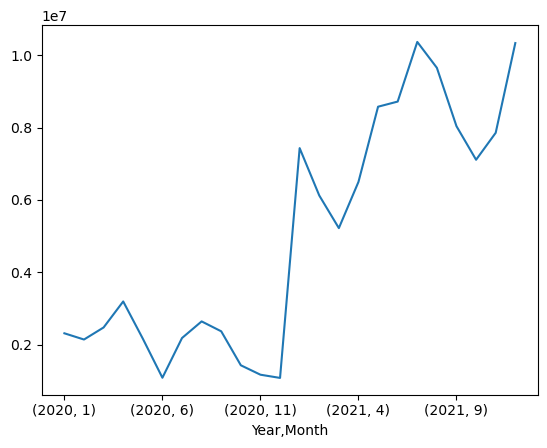

In [337]:
#plot total sales by year and month
adidas_monthly_sales.plot()
plt.show()

In [338]:
#slice for just 2020 sales
adidas_2020_sales = adidas_monthly_sales.iloc[0: 12]
adidas_2020_sales.index.names = ['Year', 'Month']
adidas_2020_sales = adidas_2020_sales.reset_index()
adidas_2020_sales = pd.DataFrame(adidas_2020_sales)
adidas_2020_sales.drop('Year', axis=1, inplace=True)
adidas_2020_sales = adidas_2020_sales.set_index('Month')
adidas_2020_sales = adidas_2020_sales.rename(
    columns={
        'Total Sales': '2020 Total Sales per Month'
    }
)
adidas_2020_sales.head(12)

,2020 Total Sales per Month
Month,
1,2312742
2,2140813
3,2474199
4,3193080
5,2164764
6,1084191
7,2182388
8,2641630
9,2367686


In [339]:
#slice for just 2021 sales
adidas_2021_sales = adidas_monthly_sales.iloc[12:]
adidas_2021_sales.index.names = ['Year', 'Month']
adidas_2021_sales = adidas_2021_sales.reset_index()
adidas_2021_sales = pd.DataFrame(adidas_2021_sales)
adidas_2021_sales.drop('Year', axis=1, inplace=True)
adidas_2021_sales = adidas_2021_sales.set_index('Month')
adidas_2021_sales = adidas_2021_sales.rename(
    columns={
        'Total Sales': '2021 Total Sales per Month'
    }
)
adidas_2021_sales.head(12)

,2021 Total Sales per Month
Month,
1,7432010
2,6123021
3,5220756
4,6498318
5,8576901
6,8718921
7,10368006
8,9651574
9,8037879


In [340]:
#sort total sales by region
adidas_monthly_sales_by_region = adidas_df.groupby(['Region', 'Year', 'Month'])['Total Sales'].sum()



print(adidas_monthly_sales_by_region)

Region   Year  Month
Midwest  2020  10        110887
               11        372082
               12        420938
         2021  1        1365832
               2        1514927
                         ...   
West     2021  8        2150828
               9        1523051
               10       1327708
               11       1746710
               12       2118455
Name: Total Sales, Length: 89, dtype: int64


In [341]:
#reset index and check format
adidas_monthly_sales_by_region = adidas_monthly_sales_by_region.reset_index()
adidas_monthly_sales_by_region.head()

,Region,Year,Month,Total Sales
0,Midwest,2020,10,110887
1,Midwest,2020,11,372082
2,Midwest,2020,12,420938
3,Midwest,2021,1,1365832
4,Midwest,2021,2,1514927


In [342]:
#slicing for only 2021 regional sales data
adidas_2021_monthly_sales_by_region = adidas_monthly_sales_by_region[adidas_monthly_sales_by_region['Year'] == 2021]
adidas_2021_monthly_sales_by_region = adidas_2021_monthly_sales_by_region.set_index('Region')
adidas_2021_monthly_sales_by_region.drop('Year', axis=1, inplace=True)
adidas_2021_monthly_sales_by_region.head()

,Month,Total Sales
Region,,
Midwest,1,1365832
Midwest,2,1514927
Midwest,3,953807
Midwest,4,624363
Midwest,5,1117221


In [343]:
#checking 2021 sales by region nulls and dtypes
adidas_2021_monthly_sales_by_region.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, Midwest to West
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Month        60 non-null     int64
 1   Total Sales  60 non-null     int64
dtypes: int64(2)
memory usage: 1.4+ KB


In [344]:
#check head and tail
display(adidas_2021_monthly_sales_by_region.head(20))
display(adidas_2021_monthly_sales_by_region.tail(20))

,Month,Total Sales
Region,,
Midwest,1,1365832
Midwest,2,1514927
Midwest,3,953807
Midwest,4,624363
Midwest,5,1117221
Midwest,6,1815567
Midwest,7,2323218
Midwest,8,1686788
Midwest,9,826204


,Month,Total Sales
Region,,
Southeast,5,1236858
Southeast,6,1944601
Southeast,7,2347401
Southeast,8,1978131
Southeast,9,1169206
Southeast,10,1166321
Southeast,11,1587786
Southeast,12,2137833
West,1,3420275


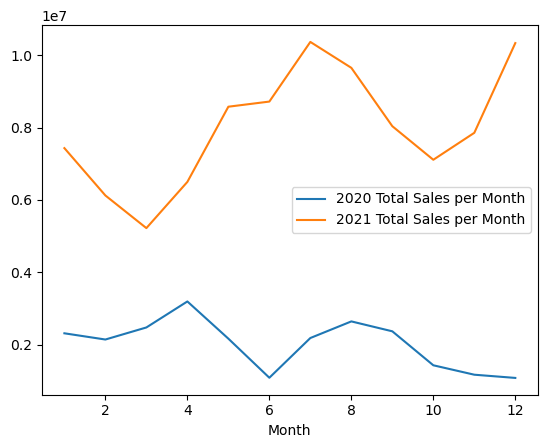

In [345]:
#plot 2020 vs 2021 total sales trends
fig, ax = plt.subplots()

adidas_2020_sales.plot(ax=ax)
adidas_2021_sales.plot(ax=ax)
plt.show()

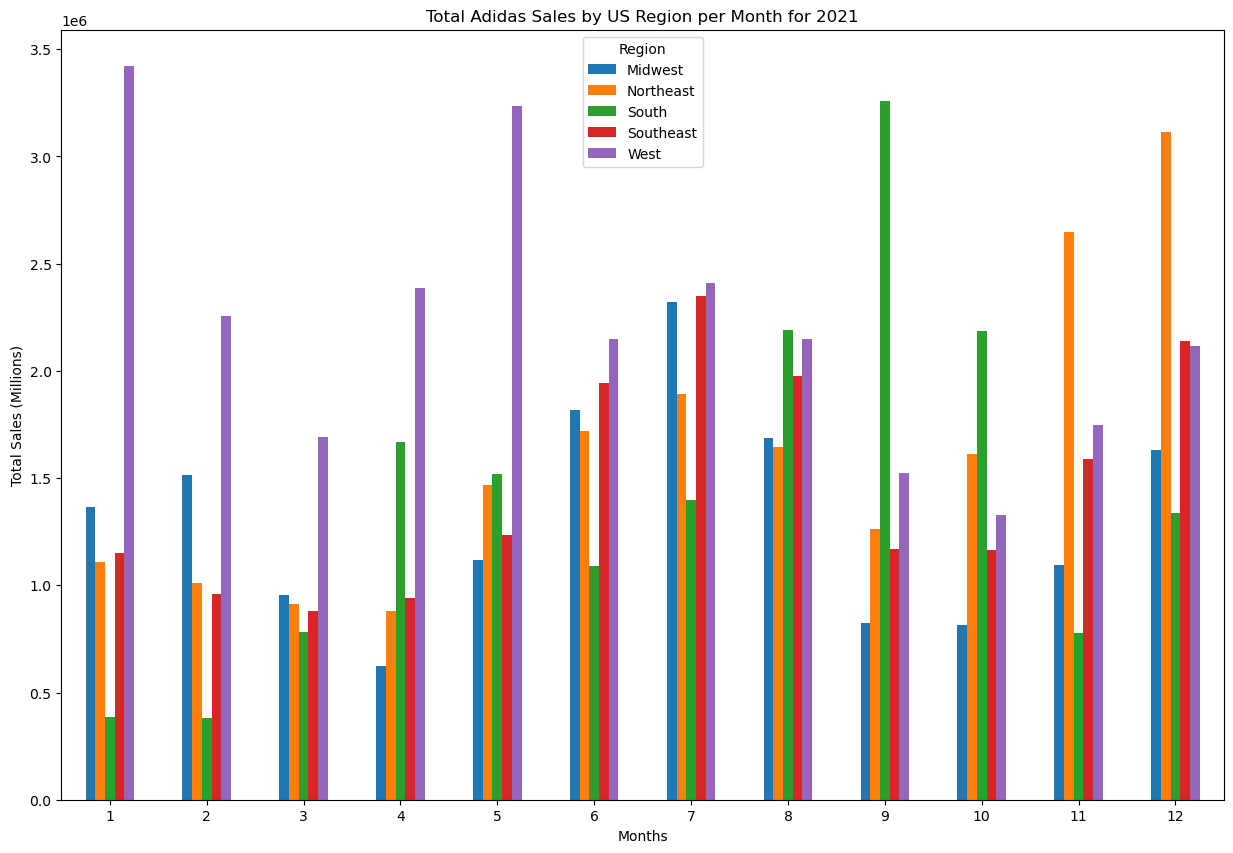

In [346]:
#plotting Total Adidas Sales by US Region per Month for 2021
adidas_2021_monthly_sales_by_region = adidas_2021_monthly_sales_by_region.groupby(['Region', 'Month'])['Total Sales'].sum().reset_index()

adidas_2021_monthly_sales_by_region.pivot(index='Month', columns='Region', values='Total Sales').plot(kind='bar', figsize=(15, 10))

plt.title('Total Adidas Sales by US Region per Month for 2021')
plt.xlabel('Months')
plt.ylabel('Total Sales (Millions)')
plt.xticks(rotation=0)
plt.show()

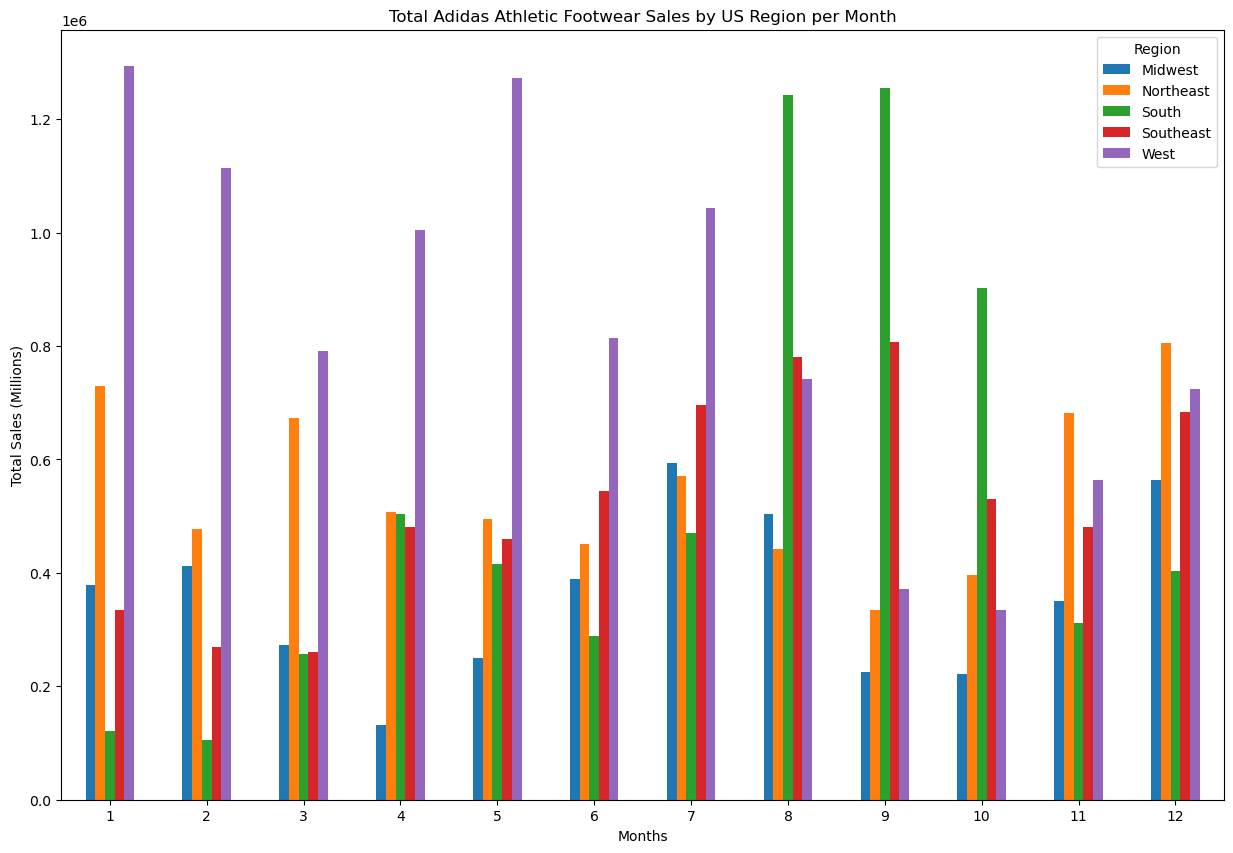

In [347]:
#plotting Total Adidas Athletic Footwear Sales by US Region per Month
adidas_footwear_by_month = adidas_footwear_by_month.groupby(['Region', 'Month'])['Total Sales'].sum().reset_index()

adidas_footwear_by_month.pivot(index='Month', columns='Region', values='Total Sales').plot(kind='bar', figsize=(15, 10))

plt.title('Total Adidas Athletic Footwear Sales by US Region per Month')
plt.xlabel('Months')
plt.ylabel('Total Sales (Millions)')
plt.xticks(rotation=0)
plt.show()

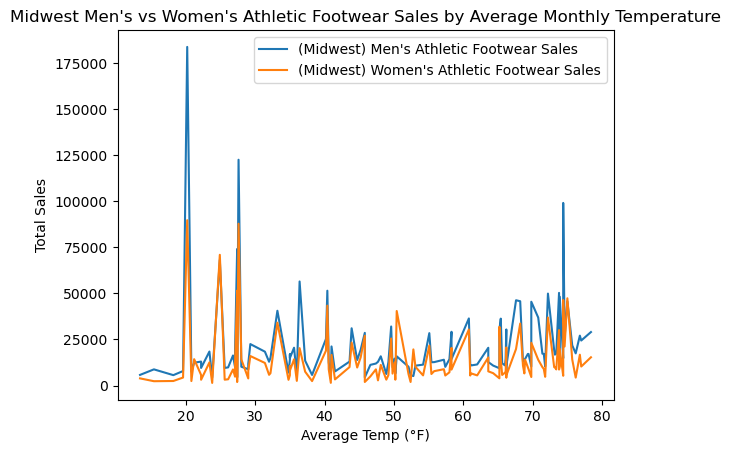

In [348]:
#plotting Midwest men vs womens sales vs temperature trends
fig, ax = plt.subplots()


mw_mens_merged.plot(ax=ax)
mw_womens_merged.plot(ax=ax)

plt.title('Midwest Men\'s vs Women\'s Athletic Footwear Sales by Average Monthly Temperature')
plt.xlabel('Average Temp (°F)')
plt.ylabel('Total Sales')
plt.show()

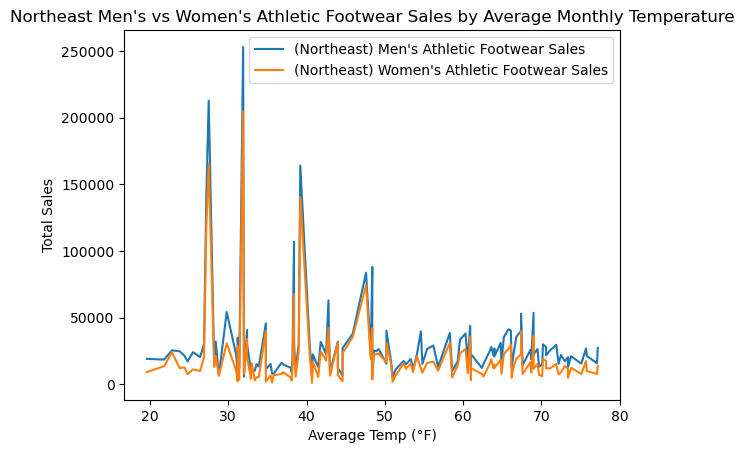

In [349]:
#plotting Northeast men vs womens sales vs temperature trends
fig, ax = plt.subplots()


ne_mens_merged.plot(ax=ax)
ne_womens_merged.plot(ax=ax)

plt.title('Northeast Men\'s vs Women\'s Athletic Footwear Sales by Average Monthly Temperature')
plt.xlabel('Average Temp (°F)')
plt.ylabel('Total Sales')
plt.show()

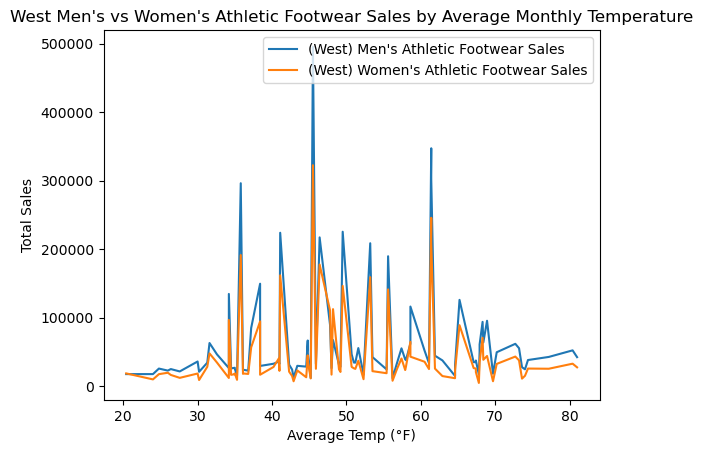

In [350]:
#plotting West men vs womens sales vs temperature trends
fig, ax = plt.subplots()


w_mens_merged.plot(ax=ax)
w_womens_merged.plot(ax=ax)

plt.title('West Men\'s vs Women\'s Athletic Footwear Sales by Average Monthly Temperature')
plt.xlabel('Average Temp (°F)')
plt.ylabel('Total Sales')
plt.show()

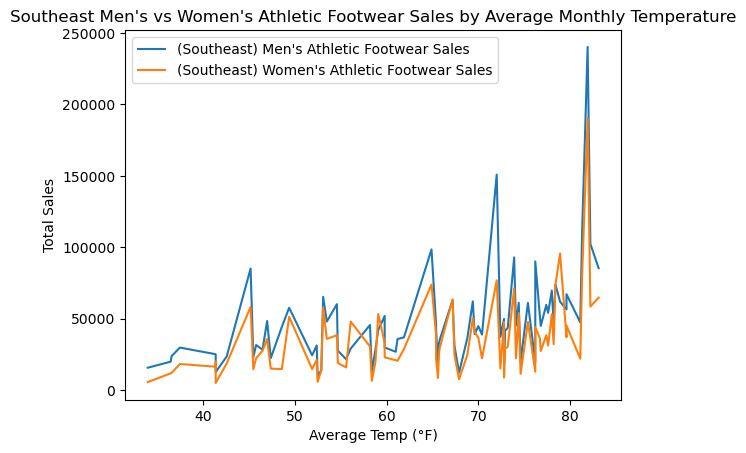

In [351]:
##plotting Southeast men vs womens sales vs temperature trends
fig, ax = plt.subplots()


se_mens_merged.plot(ax=ax)
se_womens_merged.plot(ax=ax)

plt.title('Southeast Men\'s vs Women\'s Athletic Footwear Sales by Average Monthly Temperature')
plt.xlabel('Average Temp (°F)')
plt.ylabel('Total Sales')
plt.show()

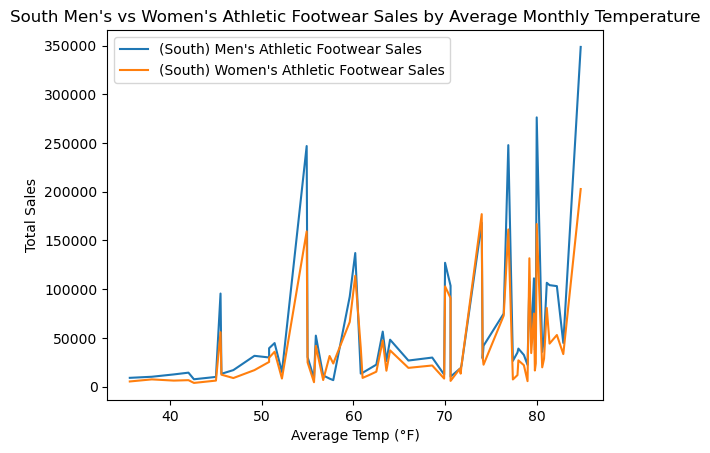

In [352]:
#plotting South men vs womens sales vs temperature trends
fig, ax = plt.subplots()


s_mens_merged.plot(ax=ax)
s_womens_merged.plot(ax=ax)

plt.title('South Men\'s vs Women\'s Athletic Footwear Sales by Average Monthly Temperature')
plt.xlabel('Average Temp (°F)')
plt.ylabel('Total Sales')
plt.show()

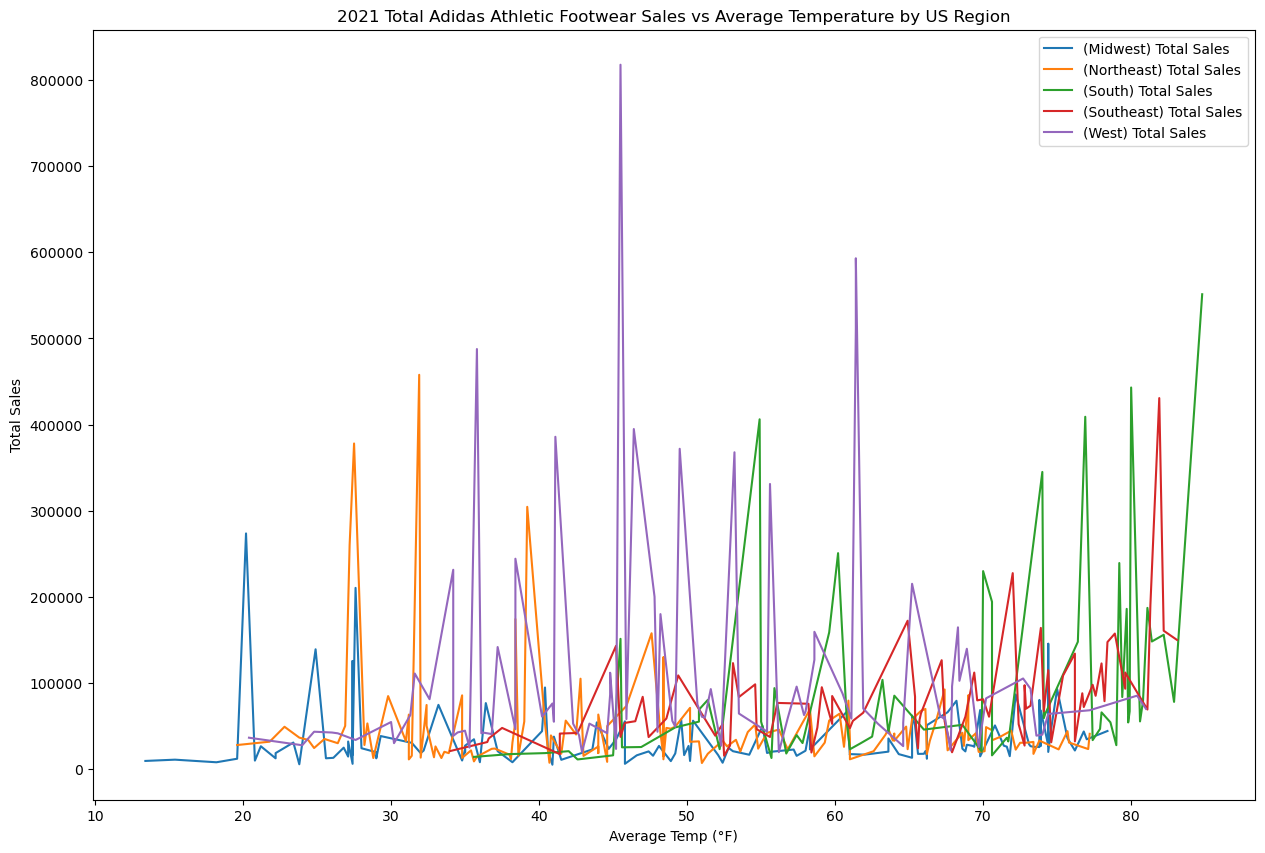

In [353]:
#plotting 2021 Total Adidas Athletic Footwear Sales vs Average Temperature by US Region
fig, ax = plt.subplots(figsize=(15, 10))

adidas_footwear_mw.plot(ax=ax)
adidas_footwear_ne.plot(ax=ax)
adidas_footwear_s.plot(ax=ax)
adidas_footwear_se.plot(ax=ax)
adidas_footwear_w.plot(ax=ax)
plt.title('2021 Total Adidas Athletic Footwear Sales vs Average Temperature by US Region')
plt.xlabel('Average Temp (°F)')
plt.ylabel('Total Sales')
plt.show()

* Based on the trend data what growth levels per category / region might we see in 2022?

In [354]:
#Create a footwear trends df with a Datetime index
adidas_trends = adidas_athletic_footwear.reset_index()
adidas_trends.drop('State', axis = 1, inplace=True)

# Merging Year and Month columns as a datetime dtype
adidas_trends['Date'] = pd.to_datetime(adidas_trends['Year'].astype(str) + '-' + adidas_trends['Month'].astype(str).str.zfill(2))


# Setting index to the new datetime 'Date' column
adidas_trends = adidas_trends.set_index('Date')

# Dropping the now irrelevant duplicate columns
adidas_trends.drop(['Year', 'Month'], axis=1, inplace=True)

#adding mens and womens sales for a Total Sales column
adidas_trends['Total Sales'] = adidas_trends['Men\'s Athletic Footwear Sales'] + adidas_trends['Women\'s Athletic Footwear Sales']

#filtering to only the needed columns
adidas_trends = adidas_trends[['Region', 'Total Sales']]

#sort by Date
adidas_trends = adidas_trends.sort_index()

#slice for only 2021 data
adidas_trends = adidas_trends.loc['2021']
adidas_trends.head()


,Region,Total Sales
Date,,
2021-01-01,West,33964
2021-01-01,Midwest,19559
2021-01-01,West,44742
2021-01-01,Northeast,36686
2021-01-01,Midwest,18705


In [355]:
#slice for Midwest and prepare data for Prophet Model
adidas_mw_trends = adidas_trends.reset_index()
adidas_mw_trends = adidas_mw_trends[['Region', 'Date', 'Total Sales']]
adidas_mw_trends = adidas_mw_trends.set_index('Region')
adidas_mw_trends = adidas_mw_trends.loc['Midwest']
adidas_mw_trends = adidas_mw_trends.reset_index()
adidas_mw_trends.drop('Region', axis=1, inplace=True)
adidas_mw_trends = adidas_mw_trends.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_mw_trends.head()

,ds,y
0,2021-01-01,19559
1,2021-01-01,18705
2,2021-01-01,12697
3,2021-01-01,21642
4,2021-01-01,210492


In [356]:
#repeat for Northeast
adidas_ne_trends = adidas_trends.reset_index()
adidas_ne_trends = adidas_ne_trends[['Region', 'Date', 'Total Sales']]
adidas_ne_trends = adidas_ne_trends.set_index('Region')
adidas_ne_trends = adidas_ne_trends.loc['Northeast']
adidas_ne_trends = adidas_ne_trends.reset_index()
adidas_ne_trends.drop('Region', axis=1, inplace=True)
adidas_ne_trends = adidas_ne_trends.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_ne_trends.head()

,ds,y
0,2021-01-01,36686
1,2021-01-01,12997
2,2021-01-01,21855
3,2021-01-01,35141
4,2021-01-01,50288


In [357]:
#repeat for West
adidas_w_trends = adidas_trends.reset_index()
adidas_w_trends = adidas_w_trends[['Region', 'Date', 'Total Sales']]
adidas_w_trends = adidas_w_trends.set_index('Region')
adidas_w_trends = adidas_w_trends.loc['West']
adidas_w_trends = adidas_w_trends.reset_index()
adidas_w_trends.drop('Region', axis=1, inplace=True)
adidas_w_trends = adidas_w_trends.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_w_trends.head()

,ds,y
0,2021-01-01,33964
1,2021-01-01,44742
2,2021-01-01,41688
3,2021-01-01,42734
4,2021-01-01,52891


In [358]:
#repeat for Southeast
adidas_se_trends = adidas_trends.reset_index()
adidas_se_trends = adidas_se_trends[['Region', 'Date', 'Total Sales']]
adidas_se_trends = adidas_se_trends.set_index('Region')
adidas_se_trends = adidas_se_trends.loc['Southeast']
adidas_se_trends = adidas_se_trends.reset_index()
adidas_se_trends.drop('Region', axis=1, inplace=True)
adidas_se_trends = adidas_se_trends.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_se_trends.head()

,ds,y
0,2021-01-01,47941
1,2021-01-01,84054
2,2021-01-01,75987
3,2021-01-01,41392
4,2021-01-01,53796


In [359]:
#repeat for South
adidas_s_trends = adidas_trends.reset_index()
adidas_s_trends = adidas_s_trends[['Region', 'Date', 'Total Sales']]
adidas_s_trends = adidas_s_trends.set_index('Region')
adidas_s_trends = adidas_s_trends.loc['South']
adidas_s_trends = adidas_s_trends.reset_index()
adidas_s_trends.drop('Region', axis=1, inplace=True)
adidas_s_trends = adidas_s_trends.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_s_trends.head()

,ds,y
0,2021-01-01,18707
1,2021-01-01,25763
2,2021-01-01,55248
3,2021-01-01,20964
4,2021-02-01,17556


In [360]:
'''Call, fit, and create future and forecast dataframes with Prophet\n
For Midwest, Northeast, West, Southeast, South, and Total 2021 datasets'''

mw_model = Prophet()
mw_model

In [361]:
ne_model = Prophet()
ne_model

In [362]:
w_model = Prophet()
w_model

In [363]:
se_model = Prophet()
se_model

In [364]:
s_model = Prophet()
s_model

In [365]:
mw_model.fit(adidas_mw_trends)

15:02:12 - cmdstanpy - INFO - Chain [1] start processing
15:02:12 - cmdstanpy - INFO - Chain [1] done processing


In [366]:
ne_model.fit(adidas_ne_trends)

15:02:13 - cmdstanpy - INFO - Chain [1] start processing
15:02:13 - cmdstanpy - INFO - Chain [1] done processing


In [367]:
w_model.fit(adidas_w_trends)

15:02:13 - cmdstanpy - INFO - Chain [1] start processing
15:02:13 - cmdstanpy - INFO - Chain [1] done processing


In [368]:
se_model.fit(adidas_se_trends)

15:02:13 - cmdstanpy - INFO - Chain [1] start processing
15:02:13 - cmdstanpy - INFO - Chain [1] done processing


In [369]:
s_model.fit(adidas_s_trends)

15:02:13 - cmdstanpy - INFO - Chain [1] start processing
15:02:13 - cmdstanpy - INFO - Chain [1] done processing


In [370]:
future_mw_trends = mw_model.make_future_dataframe(periods=9503, freq='h')

display(future_mw_trends.tail())

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [371]:
future_ne_trends = ne_model.make_future_dataframe(periods=9503, freq='h')
future_ne_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [372]:
future_w_trends = w_model.make_future_dataframe(periods=9503, freq='h')
future_w_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [373]:
future_se_trends = se_model.make_future_dataframe(periods=9503, freq='h')
future_se_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [374]:
future_s_trends = s_model.make_future_dataframe(periods=9503, freq='h')
future_s_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [375]:
forecast_mw_trends = mw_model.predict(future_mw_trends)

forecast_mw_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,32490.979676,-14385.303362,79048.779086,32490.979676,32490.979676,0.0,0.0,0.0,0.0,0.0,0.0,32490.979676
1,2021-02-01,32873.009736,-11159.158170,81709.676233,32873.009736,32873.009736,0.0,0.0,0.0,0.0,0.0,0.0,32873.009736
2,2021-03-01,33218.069072,-15245.128824,78401.061897,33218.069072,33218.069072,0.0,0.0,0.0,0.0,0.0,0.0,33218.069072
3,2021-04-01,33601.315691,-13376.875051,80769.748044,33601.315691,33601.315691,0.0,0.0,0.0,0.0,0.0,0.0,33601.315691
4,2021-05-01,33972.199512,-12783.669788,78545.181512,33972.199512,33972.199512,0.0,0.0,0.0,0.0,0.0,0.0,33972.199512


In [376]:
forecast_ne_trends = ne_model.predict(future_ne_trends)
forecast_ne_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,19926.510138,-8807.886563,48158.281992,19926.510138,19926.510138,0.0,0.0,0.0,0.0,0.0,0.0,19926.510138
1,2021-02-01,23242.598238,-5968.679737,50485.902770,23242.598238,23242.598238,0.0,0.0,0.0,0.0,0.0,0.0,23242.598238
2,2021-03-01,26237.774553,-3713.497398,54050.045808,26237.774553,26237.774553,0.0,0.0,0.0,0.0,0.0,0.0,26237.774553
3,2021-04-01,29553.862765,1718.026033,57586.850924,29553.862765,29553.862765,0.0,0.0,0.0,0.0,0.0,0.0,29553.862765
4,2021-05-01,32762.980355,5011.023003,61085.236224,32762.980355,32762.980355,0.0,0.0,0.0,0.0,0.0,0.0,32762.980355


In [377]:
forecast_w_trends = w_model.predict(future_w_trends)
forecast_w_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,109713.178475,-34657.878966,259135.122627,109713.178475,109713.178475,0.0,0.0,0.0,0.0,0.0,0.0,109713.178475
1,2021-02-01,105540.113140,-47781.805762,246600.599504,105540.113140,105540.113140,0.0,0.0,0.0,0.0,0.0,0.0,105540.113140
2,2021-03-01,101770.892845,-40457.241133,244058.419409,101770.892845,101770.892845,0.0,0.0,0.0,0.0,0.0,0.0,101770.892845
3,2021-04-01,97597.069548,-48224.055797,254318.789803,97597.069548,97597.069548,0.0,0.0,0.0,0.0,0.0,0.0,97597.069548
4,2021-05-01,93557.885732,-47718.930109,246733.271702,93557.885732,93557.885732,0.0,0.0,0.0,0.0,0.0,0.0,93557.885732


In [378]:
forecast_se_trends = se_model.predict(future_se_trends)
forecast_se_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,46922.653932,6233.883326,96198.047330,46922.653932,46922.653932,0.0,0.0,0.0,0.0,0.0,0.0,46922.653932
1,2021-02-01,51755.475918,5263.758860,98949.684625,51755.475918,51755.475918,0.0,0.0,0.0,0.0,0.0,0.0,51755.475918
2,2021-03-01,56120.605460,8657.869410,100319.069360,56120.605460,56120.605460,0.0,0.0,0.0,0.0,0.0,0.0,56120.605460
3,2021-04-01,60953.427458,16475.439674,105003.649349,60953.427458,60953.427458,0.0,0.0,0.0,0.0,0.0,0.0,60953.427458
4,2021-05-01,65630.351981,18801.792017,113039.199516,65630.351981,65630.351981,0.0,0.0,0.0,0.0,0.0,0.0,65630.351981


In [379]:
forecast_s_trends = s_model.predict(future_s_trends)
forecast_s_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,48903.742440,-74975.468499,170701.521861,48903.742440,48903.742440,0.0,0.0,0.0,0.0,0.0,0.0,48903.742440
1,2021-02-01,56198.474702,-84274.367090,187638.257768,56198.474702,56198.474702,0.0,0.0,0.0,0.0,0.0,0.0,56198.474702
2,2021-03-01,62787.265134,-63760.156353,190181.688044,62787.265134,62787.265134,0.0,0.0,0.0,0.0,0.0,0.0,62787.265134
3,2021-04-01,70081.997394,-48615.894162,196546.239852,70081.997394,70081.997394,0.0,0.0,0.0,0.0,0.0,0.0,70081.997394
4,2021-05-01,77141.415703,-44895.440597,203835.760121,77141.415703,77141.415703,0.0,0.0,0.0,0.0,0.0,0.0,77141.415703


In [380]:
display(adidas_footwear_by_month.head())


,Region,Month,Total Sales
0,Midwest,1,379202
1,Midwest,2,412842
2,Midwest,3,273225
3,Midwest,4,130927
4,Midwest,5,249306


In [381]:
# Repeating above for Total Athletic Footwear sales for 2021
adidas_footwear_by_month['Region'] = 2021

adidas_footwear_by_month.head()

,Region,Month,Total Sales
0,2021,1,379202
1,2021,2,412842
2,2021,3,273225
3,2021,4,130927
4,2021,5,249306


In [382]:
adidas_footwear_by_month['Date'] = pd.to_datetime(adidas_footwear_by_month['Region'].astype(str) + '-' + adidas_footwear_by_month['Month'].astype(str).str.zfill(2))

adidas_footwear_by_month = adidas_footwear_by_month.set_index('Date')


adidas_footwear_by_month.drop(['Region', 'Month'], axis=1, inplace=True)

adidas_footwear_by_month.head()

,Total Sales
Date,
2021-01-01,379202
2021-02-01,412842
2021-03-01,273225
2021-04-01,130927
2021-05-01,249306


In [383]:
adidas_footwear_by_month = adidas_footwear_by_month.reset_index()
adidas_footwear_by_month = adidas_footwear_by_month.rename(
    columns={
        'Date': 'ds',
        'Total Sales': 'y'
    }
)
adidas_footwear_by_month.head()

,ds,y
0,2021-01-01,379202
1,2021-02-01,412842
2,2021-03-01,273225
3,2021-04-01,130927
4,2021-05-01,249306


In [384]:
total_af_model = Prophet()
total_af_model

In [385]:
total_af_model.fit(adidas_footwear_by_month)

15:02:18 - cmdstanpy - INFO - Chain [1] start processing
15:02:18 - cmdstanpy - INFO - Chain [1] done processing


In [386]:
future_total_af_trends = total_af_model.make_future_dataframe(periods=9503, freq='h')
future_total_af_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [387]:
forecast_total_af_sales = total_af_model.predict(future_total_af_trends)
forecast_total_af_sales.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,521568.218070,146574.588920,927095.954302,521568.218070,521568.218070,0.0,0.0,0.0,0.0,0.0,0.0,521568.218070
1,2021-02-01,528490.100698,149717.900073,899637.835768,528490.100698,528490.100698,0.0,0.0,0.0,0.0,0.0,0.0,528490.100698
2,2021-03-01,534742.123711,168120.875416,934303.173834,534742.123711,534742.123711,0.0,0.0,0.0,0.0,0.0,0.0,534742.123711
3,2021-04-01,541664.006311,131132.731328,890828.680580,541664.006311,541664.006311,0.0,0.0,0.0,0.0,0.0,0.0,541664.006311
4,2021-05-01,548362.602380,173910.997403,953141.841184,548362.602380,548362.602380,0.0,0.0,0.0,0.0,0.0,0.0,548362.602380


In [388]:
# Repeating above for Adidas Total Product sales for 2021
adidas_2021_sales = adidas_2021_sales.reset_index()
adidas_2021_sales['Year'] = 2021

adidas_2021_sales['Date'] = pd.to_datetime(adidas_2021_sales['Year'].astype(str) + '-' + adidas_2021_sales['Month'].astype(str).str.zfill(2))

adidas_2021_sales.drop(['Year', 'Month'], axis=1, inplace=True)

adidas_2021_sales = adidas_2021_sales.rename(
    columns={
        'Date': 'ds',
        '2021 Total Sales per Month': 'y'
    }
)
adidas_2021_sales = adidas_2021_sales[['ds', 'y']]

adidas_2021_sales.head()

,ds,y
0,2021-01-01,7432010
1,2021-02-01,6123021
2,2021-03-01,5220756
3,2021-04-01,6498318
4,2021-05-01,8576901


In [389]:
total_model = Prophet()
total_model

In [390]:
total_model.fit(adidas_2021_sales)

15:02:19 - cmdstanpy - INFO - Chain [1] start processing
15:02:19 - cmdstanpy - INFO - Chain [1] done processing


In [391]:
future_total_trends = total_model.make_future_dataframe(periods=9503, freq='h')
future_total_trends.tail()

,ds
9510,2022-12-31 19:00:00
9511,2022-12-31 20:00:00
9512,2022-12-31 21:00:00
9513,2022-12-31 22:00:00
9514,2022-12-31 23:00:00


In [392]:
forecast_total_sales = total_model.predict(future_total_trends)
forecast_total_sales.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,6.593544e+06,4.924077e+06,8.150127e+06,6.593544e+06,6.593544e+06,0.0,0.0,0.0,0.0,0.0,0.0,6.593544e+06
1,2021-02-01,6.854452e+06,5.163179e+06,8.475898e+06,6.854452e+06,6.854452e+06,0.0,0.0,0.0,0.0,0.0,0.0,6.854452e+06
2,2021-03-01,7.090111e+06,5.410761e+06,8.631581e+06,7.090111e+06,7.090111e+06,0.0,0.0,0.0,0.0,0.0,0.0,7.090111e+06
3,2021-04-01,7.351020e+06,5.727715e+06,9.138157e+06,7.351020e+06,7.351020e+06,0.0,0.0,0.0,0.0,0.0,0.0,7.351020e+06
4,2021-05-01,7.603512e+06,6.017015e+06,9.374363e+06,7.603512e+06,7.603512e+06,0.0,0.0,0.0,0.0,0.0,0.0,7.603512e+06


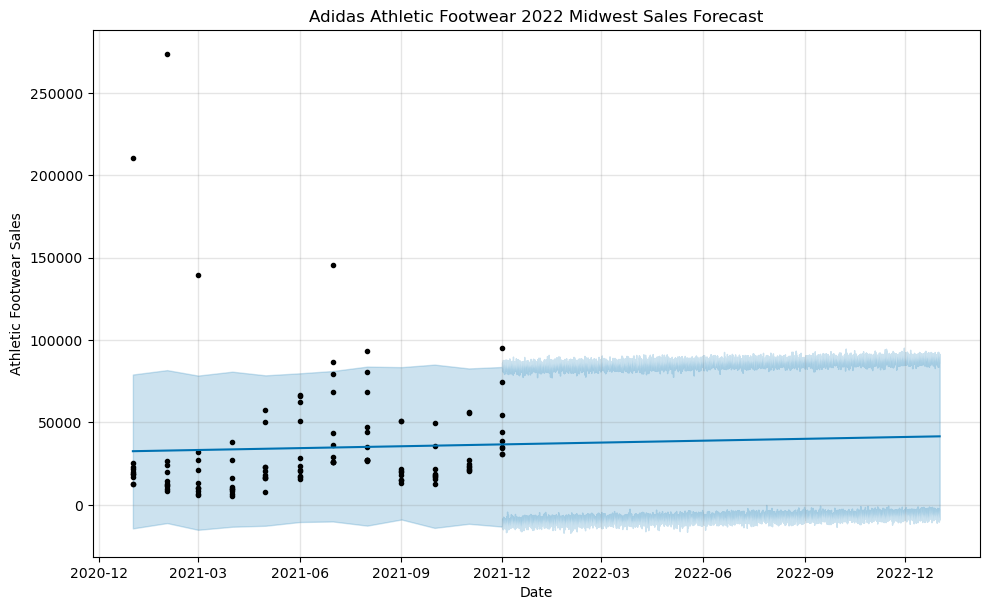

In [393]:
'''Plotting Trend Forecast Predictions for Each Region and Combined Regional Trend Forecast Predictions'''
mw_model.plot(forecast_mw_trends)
plt.title('Adidas Athletic Footwear 2022 Midwest Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Athletic Footwear Sales')
plt.show()

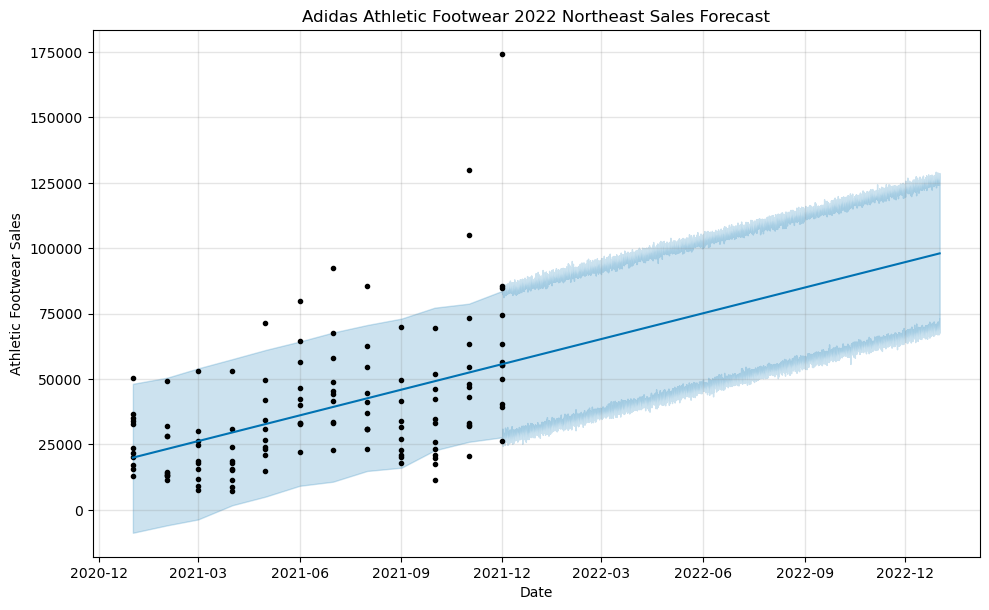

In [394]:
ne_model.plot(forecast_ne_trends)
plt.title('Adidas Athletic Footwear 2022 Northeast Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Athletic Footwear Sales')
plt.show()

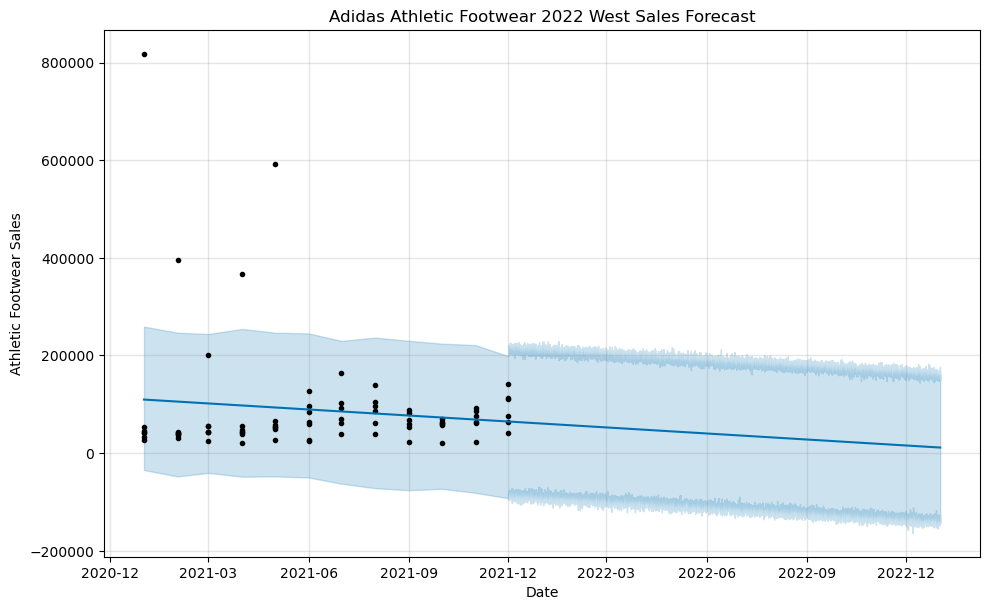

In [395]:
w_model.plot(forecast_w_trends)
plt.title('Adidas Athletic Footwear 2022 West Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Athletic Footwear Sales')
plt.show()

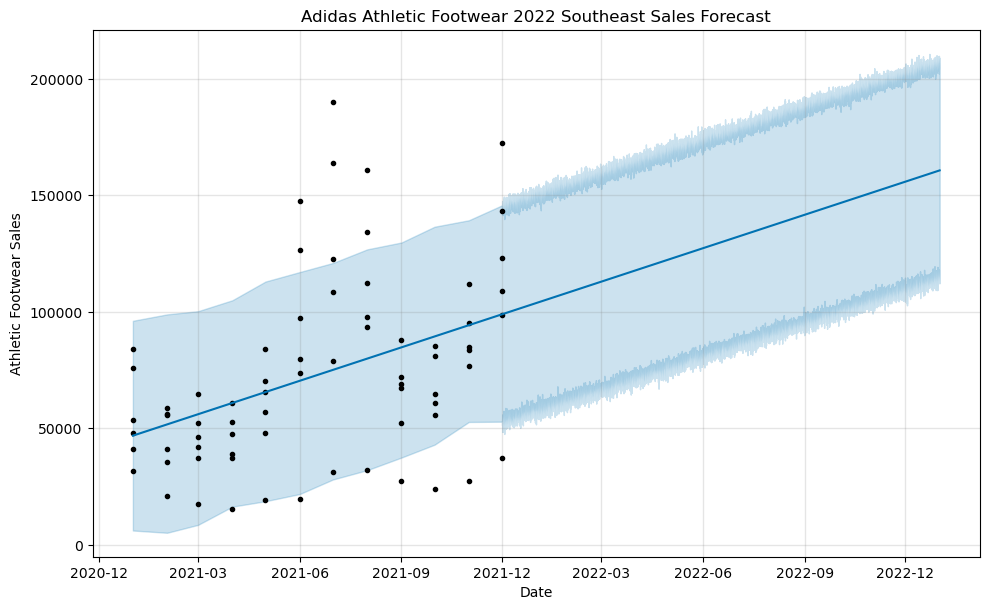

In [396]:
se_model.plot(forecast_se_trends)
plt.title('Adidas Athletic Footwear 2022 Southeast Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Athletic Footwear Sales')
plt.show()

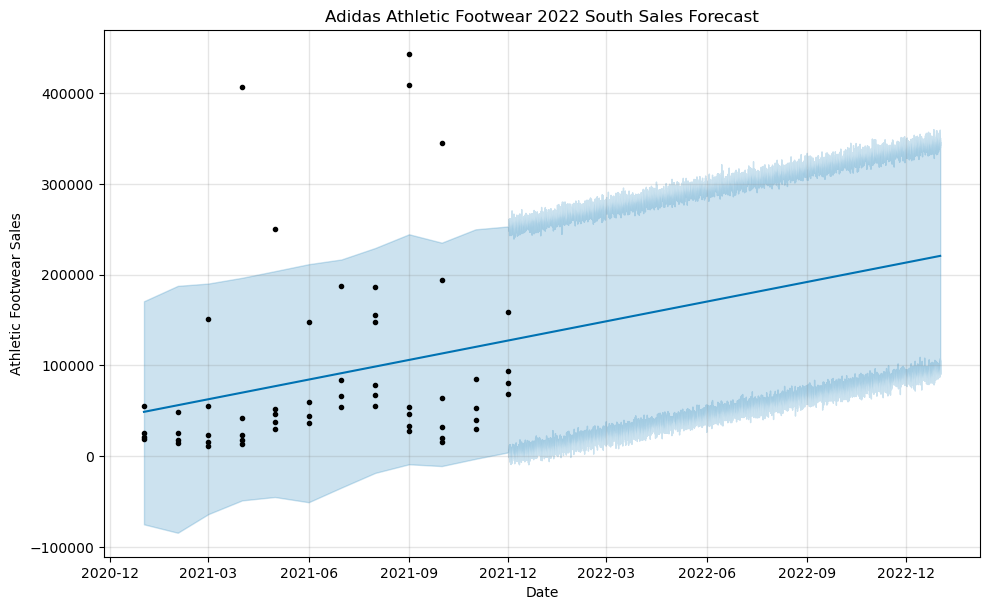

In [397]:
s_model.plot(forecast_s_trends)
plt.title('Adidas Athletic Footwear 2022 South Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Athletic Footwear Sales')
plt.show()

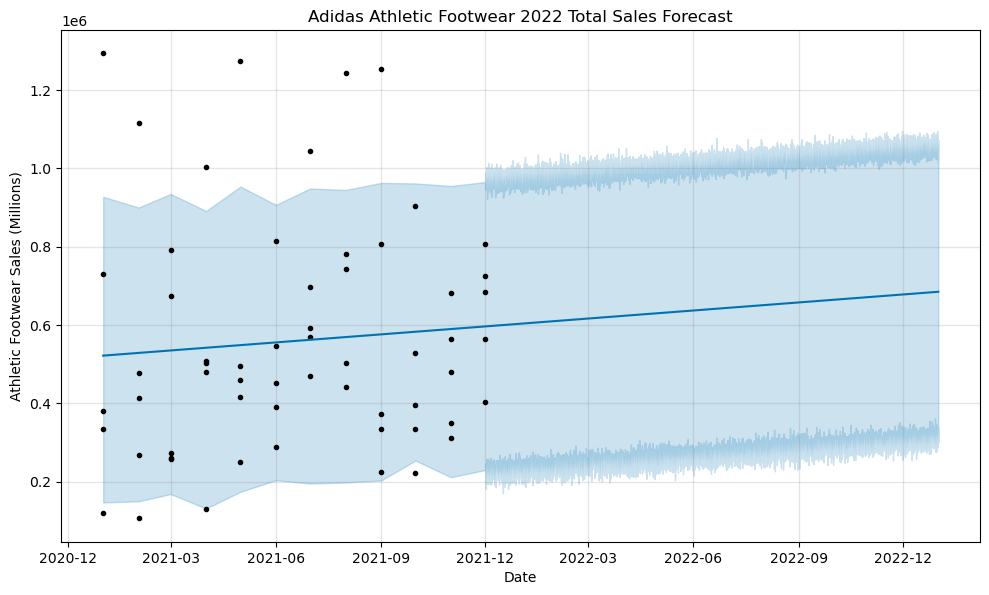

In [398]:
total_af_model.plot(forecast_total_af_sales)
plt.title('Adidas Athletic Footwear 2022 Total Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Athletic Footwear Sales (Millions)')
plt.show()

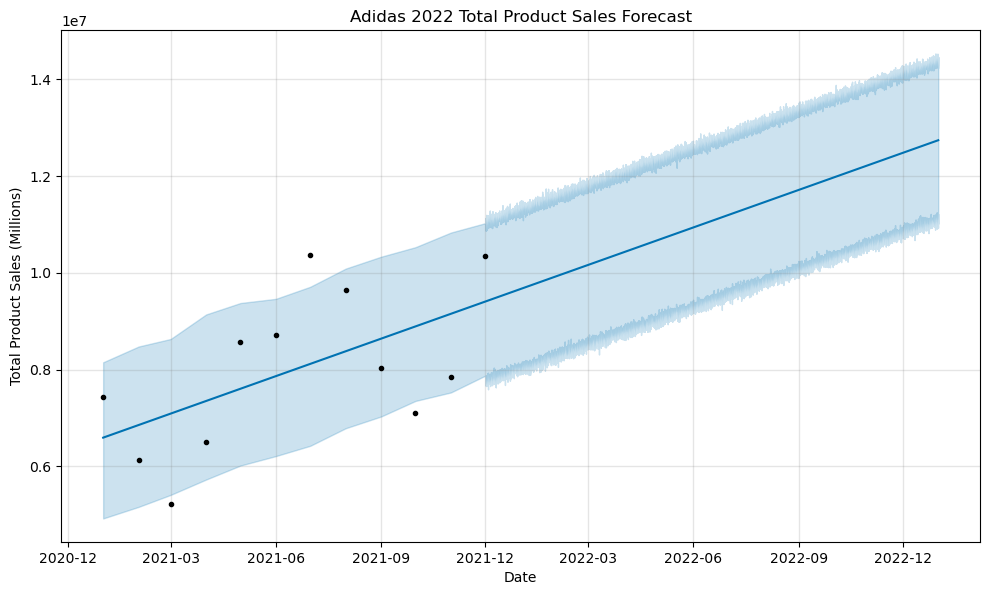

In [399]:
total_model.plot(forecast_total_sales)
plt.title('Adidas 2022 Total Product Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Total Product Sales (Millions)')
plt.show()

# Based on the trend data what growth levels per category / region might we see in 2022?

* Based on the __Trend data__, we can see __slight upwards Sales trends__ going into __2022__ for the __Midwest region__, with __much greater upwards trends__ for the __Northeast__ and __South__ regions, while the __Southeast__ region shows the __highest upward trend__, also having the __highest predicted total sales__ of __all__ the __regions__.

* The __West__ region __trend data__ shows it has a __higher average Total Sales__ than the other regions, __but__ it is the __only region__ on a __downward sales trend__.

* The __combined Region Data__ for __Adidas Athletic Footwear sales__ show a __steady upward Trend__, while the __combined product Sales Data__ shows a __much stronger upwards Trend__ for __2022__ in the __US__, __implying other Adidas products have higher sales on avg__ than __Athletic Footwear__.